In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator,MaxNLocator)
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.interpolate import interp1d
from scipy.misc import derivative
import inspect
from scipy.optimize import curve_fit as fit
import scipy.integrate as scint
from scipy.special import spherical_jn as jn
from itertools import groupby
import tqdm
import parmap
import time
import pywigxjpf as wig
from scipy.linalg._matfuncs_sqrtm_triu import within_block_loop
import gmpy2
import mpmath
from scipy import integrate

from numba import jit, njit, prange

import sympy as sy
import camb
from ipykernel import kernelapp as app


#plotParameters();
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# definition of Wigner symbols 3j-6j-9j. It works well, but very numerically
# expensive for lmax>20000. Need more than 100 GB to handle lmax=100000, crazy

wig.wig_table_init(40002,3)
wig.wig_temp_init(40002)

def w3j(l1,l2,l3,m1,m2,m3):
    return wig.wig3jj(2*l1, 2*l2, 2*l3, 2*m1, 2*m2, 2*m3)

def w6j(l1,l2,l3,l4,l5,l6):
    return wig.wig6jj(2*l1, 2*l2, 2*l3, 2*l4, 2*l5, 2*l6)

def w9j(l1,l2,l3,l4,l5,l6,l7,l8,l9):
    return wig.wig9jj(2*l1, 2*l2, 2*l3, 2*l4, 2*l5, 2*l6, 2*l7, 2*l8, 2*l9)

In [3]:
# remove the previous Wigner symbols (to be used at the end)

# wig.wig_table_free()
# wig.wig_temp_free()

In [4]:
# low-memory definition of Wigner symbol 3j, valid when m1 = m2 = m3 = 0

def wigner3jm0(l1,l2,l3):
    if l3 >l1+l2 or l3 < np.abs(l1-l2) or (l1+l2+l3) % 2== 1:
        value = 0.
        return value
    else:
        factor1 = mpmath.factorial(l1/2+l2/2+l3/2)
        factor2 = mpmath.factorial(-l1/2+l2/2+l3/2)
        factor3 = mpmath.factorial(l1/2-l2/2+l3/2)
        factor4 = mpmath.factorial(l1/2+l2/2-l3/2)
    
        sq1 = mpmath.sqrt(mpmath.factorial(-l1+l2+l3))
        sq2 = mpmath.sqrt(mpmath.factorial(l1-l2+l3))
        sq3 = mpmath.sqrt(mpmath.factorial(l1+l2-l3))
    
        sq4 = mpmath.sqrt(mpmath.factorial(l1+l2+l3+1))
    
        value = (-1)**(-l1/2-l2/2-l3/2)*factor1*sq1*sq2*sq3/factor2/factor3/factor4/sq4
    
        return float(value)

# IMPORT CMB TRANSFER FUNCTIONS AND POWER SPECTRA

In [5]:
#l, TT, EE, BB, TE
lcmb2,tcmb2,ecmb2,bcmb2,tecmb2 = np.loadtxt('CMBpower0.01.dat', unpack = True)
lcmb3,tcmb3,ecmb3,bcmb3,tecmb3 = np.loadtxt('CMBpower0.001.dat', unpack = True)



cmbtrt = []
cmbtrs = []


# import tensor transfer
with open('transfer_tensor.dat') as f_data:    
    for k, g in groupby(f_data, lambda x: x.startswith('\n')):
        if not k:
            cmbtrt.append(np.array([[float(x) for x in d.split()] for d in g if len(d.strip())]))

cmbtrt=np.array(cmbtrt)
llist=np.zeros(len(cmbtrt))
for i in range(len(cmbtrt)):
    llist[i]=cmbtrt[i][0][0]
llist=llist.astype(int)


# import scalar transfer
with open('transfer_scalar.dat') as f_data:    
    for k, g in groupby(f_data, lambda x: x.startswith('\n')):
        if not k:
            cmbtrs.append(np.array([[float(x) for x in d.split()] for d in g if len(d.strip())]))

            
cmbtrs=np.array(cmbtrs)
llists=np.zeros(len(cmbtrs))
for i in range(len(cmbtrs)):
    llists[i]=cmbtrs[i][0][0]
llists=llists.astype(int)

In [6]:
#functions calling CMB PS with correct normalization, in the end we take r = 0.01, nothing really changes

def cTT(i,r):
    l=llist[i]
    if r == 0.01:
        val = tcmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = tcmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val


def cEE(i,r):
    l=llist[i]
    if r == 0.01:
        val = ecmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = ecmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val


def cET(i,r):
    l=llist[i]
    if r == 0.01:
        val = tecmb2[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2) 
    elif r == 0.001:
        val = tecmb3[i]/(10**12*l*(l+1)/(2*np.pi)*2.7255**2)
    return val

# collecting CMB spectra
cTTspectra = np.array([cTT(i,0.01) for i in range(len(llist))])
cEEspectra = np.array([cEE(i,0.01) for i in range(len(llist))])
cETspectra = np.array([cET(i,0.01) for i in range(len(llist))])

# LOAD 21-cm Baryon Transfer from CAMB, Same Cosmology 

In [24]:
pars=camb.set_params(H0=67.32117, ombh2= 0.0223828, omch2= 0.1201075, tau =0.05430842,
                     As= 2.100549e-9, ns= 0.9660499)
#pars=camb.read_ini('planck_2018_acc.ini')

pars.Do21cm  =True

pars.Evolve_delta_xe =True # ionization fraction perturbations
pars.Evolve_baryon_cs  = True # accurate baryon perturbations
pars.WantCls =False
pars.SourceTerms.use_21cm_mK = False # Use dimensionless rather than mK units
redshifts=[30,50,100] # The red-shifts in use in the paper, can change if you want
pars.set_matter_power(kmax=300., redshifts=redshifts)
pars.Accuracy.AccuracyBoost = 1.

# get baryon_etc-transfer functions
results= camb.get_results(pars)
trans = results.get_matter_transfer_data().transfer_data
trans = np.flip(trans,axis=-1)

Note: redshifts have been re-sorted (earliest first)


In [35]:
# interpolation of baryonic transfer function, for the red-shifts selected
k = trans[0,:,0]*results.Params.h
mono30 = trans[2,:,0]
mono50 = trans[2,:,1]
mono100 = trans[2,:,2]
monoz = trans[2,:,:]

mono30f=interpolate(k,mono30*k**2)

mono50f=interpolate(k,mono50*k**2)

mono100f=interpolate(k,mono100*k**2)

monozf = interp1d(k,monoz*k[:,np.newaxis]**2,axis=0,kind='cubic',bounds_error=False,fill_value="extrapolate")

TypeError: 'function' object is not subscriptable

# DEFINE USEFUL FUNCTIONS 

In [36]:
# Hubble parameter H(z)
def H(z):
    value = results.h_of_z(z)
    return value

# conformal time \eta(z)
def eta(z):
    value = results.conformal_time(z)
    return value

# co-moving distance r(z)
def r(z):
    integrand =  lambda x: 1/H(x)
    int = scint.quad(integrand,0,z)
    return int[0]

# compute co-moving distance at selected red-shifts and recomb
r30 = r(30)
r50 = r(50)
r100 = r(100)
r1100 = r(1100)

# scale factor a(z)
def a(z):
    value = 1/(1+z)
    return value

# dimensionless scalar PS
def scalarpower(q):
    value = 2*np.pi**2*pars.scalar_power(q)/q**3
    return value

# 21-cm transfer from Munoz et. al. arXiv:1506.04152
def trans(qpar,l,r,z):
    if z==30:
        alpha = alp1r(r30)
        T = t21r(r30)
    elif z==50:
        alpha = alp1r(r50)
        T = t21r(r50)
    elif z==100:
        alpha = alp1r(r100)
        T = t21r(r100)
    value = (alpha + T*qpar**2/(qpar**2+l**2/r**2))
    return value

# Omega_m
Omegam = 0.0223828+0.1201075

# Window function 21-cm Fourier space
def Wq(qpar,z,dnu):
    deltaD = 17*np.sqrt((1+z)/10*0.15/Omegam)*dnu/2
    value = np.exp(-qpar**2*deltaD**2/2)
    return value


# radial direction resolution
def deltar(z,dnu):
    return np.sqrt((1+z)/10*0.15/Omegam)*(dnu/0.1)

# Window function 21-cm
def W(rmean,r,z,dnu):
    deltar = 17*np.sqrt((1+z)/10*0.15/Omegam)*dnu
    value = 1/deltar/np.sqrt(2*np.pi)*np.exp(-1/2*(r-rmean)**2/deltar**2)
    return value

In [37]:
np.sqrt(8*np.log(2)), 2 # optional for future: check this factor substitution in Wq definition

(2.3548200450309493, 2)

In [38]:
# importing \alpha(z) and T(z) coefficients, from Floss et. al.:2201.08843

z,a11,a22,a33,a21,a31,a32 = np.loadtxt('alpha_coefficients_21.dat', unpack = True)
z21,T21 = np.loadtxt('T21.dat', unpack = True)


listz = np.arange(20,110)
listr = np.array([r(z) for z in listz])

alp1=interpolate(z,a11)
listalp1 = np.array([alp1(z) for z in listz])
alp1r = interpolate(listr,listalp1)

alp2=interpolate(z,a22)
listalp2 = np.array([alp2(z) for z in listz])
alp2r = interpolate(listr,listalp2)

alp3=interpolate(z,a21)
listalp3 = np.array([alp3(z) for z in listz])
alp3r = interpolate(listr,listalp3)


t21=interpolate(z21,T21)
listt21 = np.array([t21(z) for z in listz])
t21r = interpolate(listr,listt21)

In [39]:
# sampling of y for each red-shift, works for Delta_nu < 0.1 MHz. Need to modify 
# ymin and ymax for other frequency resolutions

y30 = np.linspace(r30-7,r30+7,15)
y50 = np.linspace(r50-7,r50+7,15)
y100 = np.linspace(r100-7,r100+7,15)

# sampling of y for each red-shift, works for Delta_nu = 1 MHz. Need to modify 
# ymin and ymax 

y301 = np.linspace(r30-100,r30+100,100)
y501 = np.linspace(r50-100,r50+100,100)
y1001 = np.linspace(r100-100,r100+100,100)

In [40]:
# c parameters describing secondaries 

c1 = 5/7
c2 = 1/2
c3 = 2/7

d0 = c1+c3/3
d2 = 2/3*c3

In [41]:
# ratio between primordial and leading secondary coefficients

def estimation(z):
    value = alp1(z)/(alp2(z)*d0+alp3(z))
    return value

In [42]:
est = np.array([estimation(z) for z in listz])

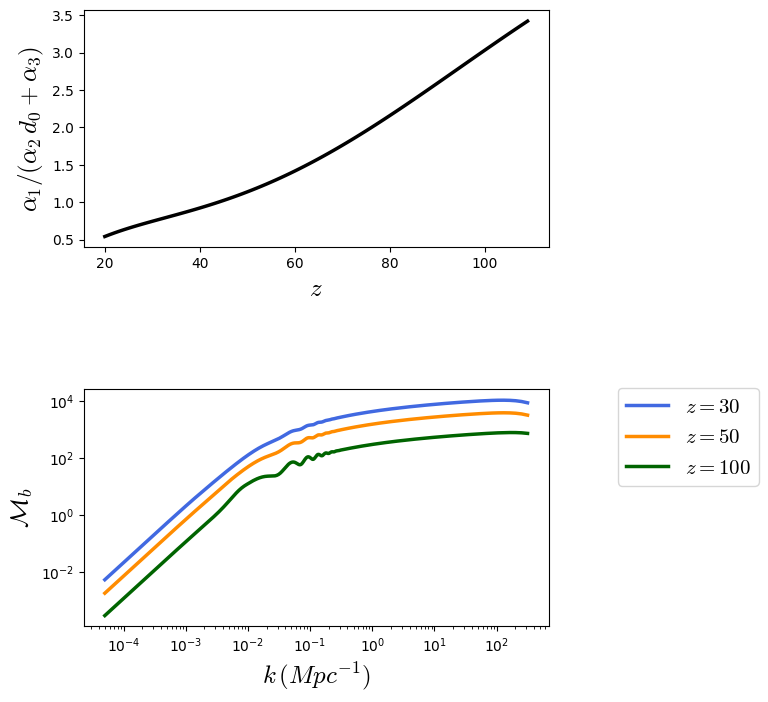

In [43]:
# Plot of ratio between primordial and leading secondary coefficients
# +baryon transfer function

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))



fig.subplots_adjust(hspace=0.6)



ax1.set_xlabel(r'$z$', fontsize=18)
ax2.set_xlabel(r'$k \, (Mpc^{-1})$', fontsize=18)


ax1.set_ylabel(r'$\alpha_{1}/(\alpha_{2} \, d_0 + \alpha_{3})$', fontsize=18)
ax2.set_ylabel(r'${\cal M}_b$', fontsize=18)

#ax1.set_xscale('log')
ax2.set_xscale('log')

#ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.plot(listz,estimation(listz), linewidth = 2.5,color = 'black', linestyle = '-', zorder = 10)


ax2.plot(k,mono30f(k), label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax2.plot(k,mono50f(k), label = '$z=50$', color = 'darkorange', linewidth = 2.5, linestyle = '-', zorder = 10)
ax2.plot(k,mono100f(k), label = '$z=100$', color = 'darkgreen', linewidth = 2.5, linestyle = '-', zorder = 10)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


plt.savefig("est.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

# COMPUTATION OF PRIMORDIAL AND SECONDARY SIGNALS

In [44]:
# CMB k3-integral, <21-21-T>


def factor2(l):
    return (l+2)*(l+1)*l*(l-1)
    
# primordial I_1
def CMBprim_I1(i,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum("ij,jk->ijk",- jn(l,kr)*pars.scalar_power(cmbtrs[i,:,1])/cmbtrs[i,:,1],cmbtrans)
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# primordial I_2
def CMBprim_I2(i,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum("ij,jk->ijk"- jn(l,kr)*cmbtrs[i,:,1]**2,cmbtrans)
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# secondary I_1 z=30
def CMBsec_I1(i,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum('ij,jk,jl->ijkl',- jn(l,kr)*pars.scalar_power(cmbtrs[i,:,1])/cmbtrs[i,:,1],cmbtrans,monozf(cmbtrs[i,:,1]))
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# secondary I_2 z=30
def CMBsec_I2(i,L3,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum('ij,jk,jl->ijkl',- jn(L3,kr)*pars.scalar_power(cmbtrs[i,:,1])/cmbtrs[i,:,1]**2,cmbtrans,monozf(cmbtrs[i,:,1]))
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# secondary I_3 z=30
def CMBsec_I3(i,L3,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum('ij,jk,jl->ijkl',- jn(L3,kr)*pars.scalar_power(cmbtrs[i,:,1]),cmbtrans,monozf(cmbtrs[i,:,1]))
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# secondary I_4 z=30
def CMBsec_I4(i,L3,y):
    if np.isscalar(y):
        y = np.array([y])
    l=llist[i]
    cmbtrans = cmbtrs[i,:,2:4].copy()
    cmbtrans[:,1] *= np.sqrt(factor2(l))
    kr = np.einsum("i,j->ij",y,cmbtrs[i,:,1])
    integrand = np.einsum('ij,jk,jl->ijkl',- jn(L3,kr)*pars.scalar_power(cmbtrs[i,:,1])/cmbtrs[i,:,1],cmbtrans,monozf(cmbtrs[i,:,1]))
    inte = integrate.simps(integrand,x=cmbtrs[i,:,1], axis=1)
    return inte

# CMB T-mode PS, just to check normalizations are ok
def CMBspec(i):
    l=llist[i]
    ktr=np.zeros(int(len(cmbtrs[i][:])))
    ctr=np.zeros(int(len(cmbtrs[i][:])))
    for j in range(int(len(cmbtrs[i][:]))):
        ktr[j]=cmbtrs[i][j][1]
        ctr[j]=cmbtrs[i][j][2]
    T=interpolate(ktr,-ctr)
    integrand = lambda q: T(q)**2*pars.scalar_power(q)/q
    qmin = ktr[0]
    qmax = ktr[-1]
    inte = scint.quad(integrand,qmin,qmax, epsabs=0.,epsrel=1e-4, limit = 10000000)[0]
    f =  4*np.pi
    value = f*inte
    return value

In [45]:
# R-terms as in the paper

# Eq. 49
R30T, R50T, R100T = np.array([CMBprim_I1(i,[r30,r50,r100])[:,0]**2/cTT(i,0.01)  for i in np.arange(0,20)]).T

# Eq. 59
R30ET, R50ET, R100ET = np.array([(CMBprim_I1(i,[r30,r50,r100])[:,0]**2*cEE(i,0.01)+CMBprim_I1(i,[r30,r50,r100])[:,1]**2*cTT(i,0.01)-2*CMBprim_I1(i,[r30,r50,r100]).prod(1)*cET(i,0.01))/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)]).T

# Eq. 63
R30Tsec, R50Tsec, R100Tsec = np.array([np.diag(CMBsec_I1(i,[r30,r50,r100])[:,0,:])**2/cTT(i,0.01)  for i in np.arange(0,20)]).T

# Eq. 64
R30ETsec, R50ETsec, R100ETsec = np.array([(np.diag(CMBsec_I1(i,[r30,r50,r100])[:,0,:])**2*cEE(i,0.01)+np.diag(CMBsec_I1(i,[r30,r50,r100])[:,1,:])**2*cTT(i,0.01)-2*np.diag(CMBsec_I1(i,[r30,r50,r100])[:,:,:].prod(1))*cET(i,0.01))/(cTT(i,0.01)*cEE(i,0.01)-cET(i,0.01)**2)  for i in np.arange(0,20)]).T

# l for plots
lplot = np.array([i+2  for i in np.arange(0,20)])

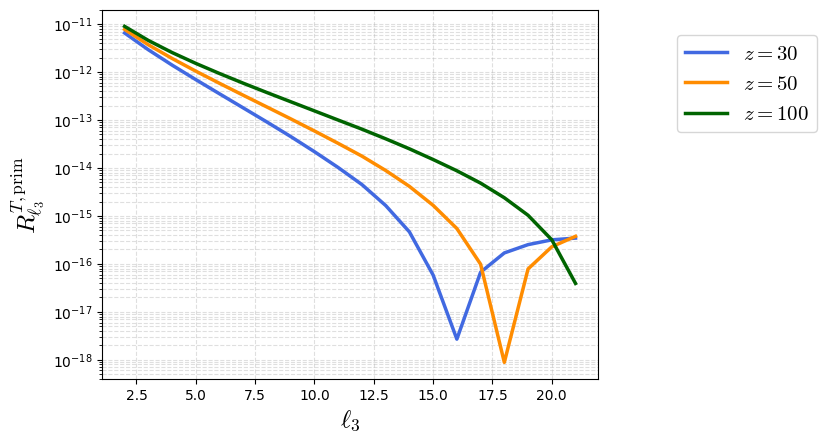

In [46]:
# Plot of R^{T, prim}

plt.figsize=(6, 8)

plt.xlabel(r'$\ell_3$', fontsize=18)


plt.ylabel(r'$R^{T, \rm prim}_{\ell_3}$', fontsize=18)



plt.yscale('log')



plt.plot(lplot,R30T,label = r'$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R50T,label = r'$z=50$', color = 'darkorange',linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R100T,label = r'$z=100$', color = 'darkgreen',linewidth = 2.5, linestyle = '-', zorder = 10)

plt.grid(True, which='both',linestyle='--', alpha = 0.4)

plt.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)

plt.savefig("RTpriml3.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

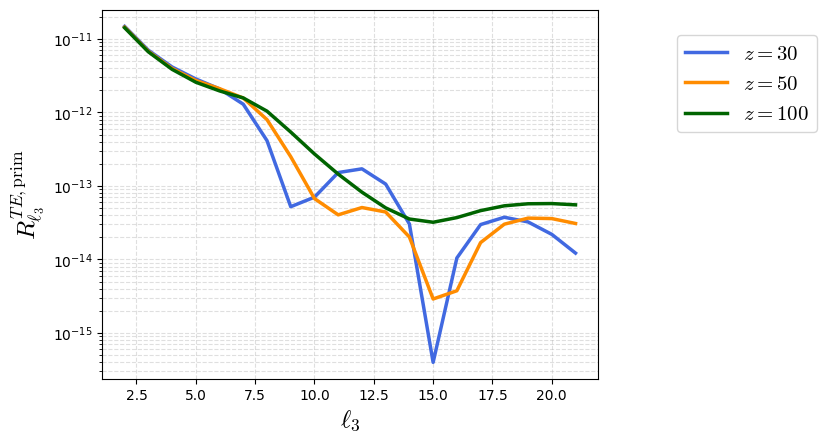

In [47]:
# Plot of R^{TE, prim}

plt.figsize=(6, 8)

plt.xlabel(r'$\ell_3$', fontsize=18)


plt.ylabel(r'$R^{TE, \rm prim}_{\ell_3}$', fontsize=18)



plt.yscale('log')



plt.plot(lplot,R30ET,label = r'$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R50ET,label = r'$z=50$', color = 'darkorange',linewidth = 2.5, linestyle = '-', zorder = 10)
plt.plot(lplot,R100ET,label = r'$z=100$', color = 'darkgreen',linewidth = 2.5, linestyle = '-', zorder = 10)

plt.grid(True, which='both',linestyle='--', alpha = 0.4)

plt.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)

plt.savefig("RTEpriml3.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

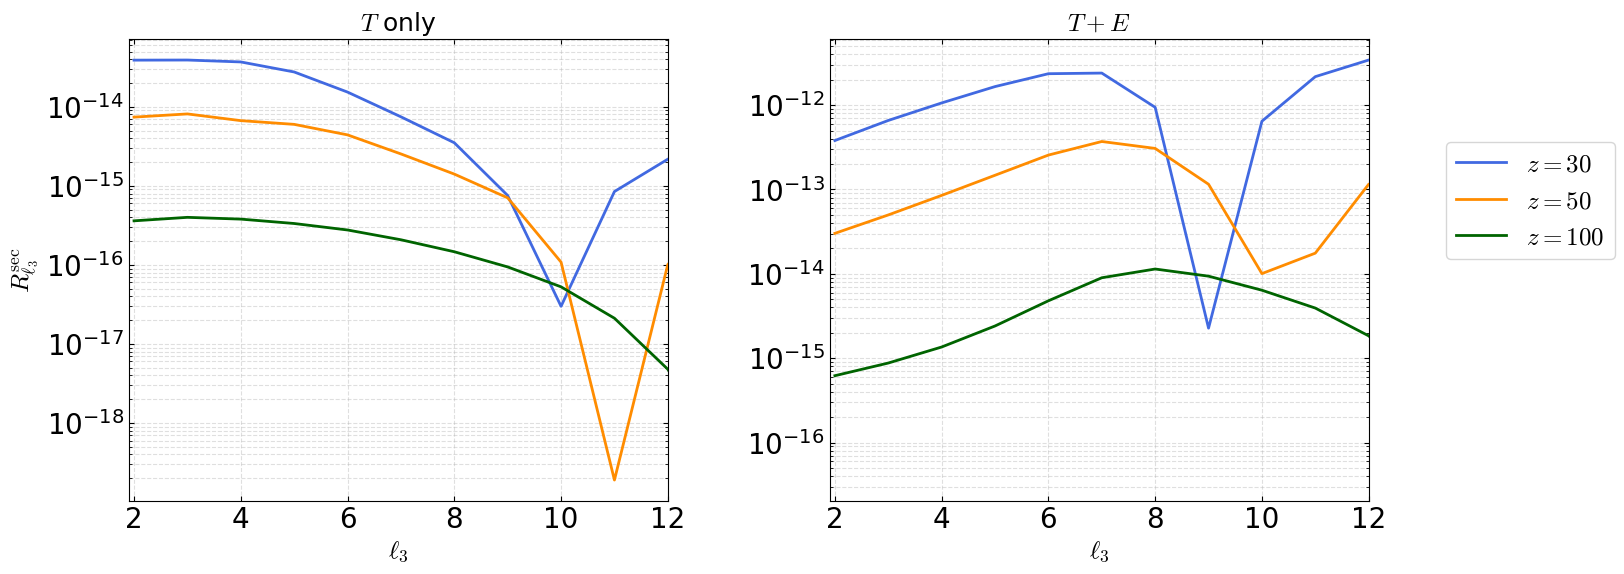

In [48]:
# Plot of R^{T, sec} and R^{ET, sec}

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$T$ only', fontsize=18)
ax2.set_title(r'$T+E$', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)




ax1.set_xlim(1.9,12)
ax2.set_xlim(1.9,12)


ax1.set_ylabel(r'$R^{\rm sec}_{\ell_3}$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')



ax1.plot(lplot,R30Tsec, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(lplot,R50Tsec, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(lplot,R100Tsec, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

ax2.plot(lplot,R30ETsec, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(lplot,R50ETsec, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(lplot,R100ETsec, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


ax2.legend(bbox_to_anchor=(1.30, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)



ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax1.grid(True, which='both',linestyle='--', alpha = 0.4)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax2.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("Rsecvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [49]:
CMBprim30 = np.array([CMBprim_I1(i, y30) for i in np.arange(0,20)])
CMBprim30.shape

(20, 15, 2)

In [50]:
# Creating y-l3 samplings of k3-integrals

CMBprim30 = np.array([CMBprim_I1(i, y30) for i in np.arange(0,20)])
CMBprim50 = np.array([CMBprim_I1(i, y50) for i in np.arange(0,20)])
CMBprim100 = np.array([CMBprim_I1(i, y100) for i in np.arange(0,20)])

CMBprim230 = np.array([[CMBprim2(i, yp) for yp in y30] for i in np.arange(0,20)])
CMBprim250 = np.array([[CMBprim2(i, yp) for yp in y50] for i in np.arange(0,20)])
CMBprim2100 = np.array([[CMBprim2(i, yp) for yp in y100] for i in np.arange(0,20)])

CMBprim30pol = np.array([[CMBprimpol(i, yp) for yp in y30] for i in np.arange(0,20)])
CMBprim50pol = np.array([[CMBprimpol(i, yp) for yp in y50] for i in np.arange(0,20)])
CMBprim100pol = np.array([[CMBprimpol(i, yp) for yp in y100] for i in np.arange(0,20)])

CMBprim230pol = np.array([[CMBprim2pol(i, yp) for yp in y30] for i in np.arange(0,20)])
CMBprim250pol = np.array([[CMBprim2pol(i, yp) for yp in y50] for i in np.arange(0,20)])
CMBprim2100pol = np.array([[CMBprim2pol(i, yp) for yp in y100] for i in np.arange(0,20)])

CMBsecf30 = np.array([[CMBsecfirst30(i, yp) for yp in y30] for i in np.arange(0,20)])
CMBsecf50 = np.array([[CMBsecfirst50(i, yp) for yp in y50] for i in np.arange(0,20)])
CMBsecf100 = np.array([[CMBsecfirst100(i, yp) for yp in y100] for i in np.arange(0,20)])

CMBsecf30pol = np.array([[CMBsecfirst30pol(i, yp) for yp in y30] for i in np.arange(0,20)])
CMBsecf50pol = np.array([[CMBsecfirst50pol(i, yp) for yp in y50] for i in np.arange(0,20)])
CMBsecf100pol = np.array([[CMBsecfirst100pol(i, yp) for yp in y100] for i in np.arange(0,20)])


# def CMBsecs30(i,L3):
#     value = np.array([CMBsecsecond30(i,L3, yp) for yp in y30])
#     return value

# def CMBsecs50(i,L3):
#     value = np.array([CMBsecsecond50(i,L3, yp) for yp in y50])
#     return value

# def CMBsecs100(i,L3):
#     value = np.array([CMBsecsecond100(i,L3, yp) for yp in y100])
#     return value


# def CMBsecs30pol(i,L3):
#     value = np.array([CMBsecsecond30pol(i,L3, yp) for yp in y30])
#     return value

# def CMBsecs50pol(i,L3):
#     value = np.array([CMBsecsecond50pol(i,L3, yp) for yp in y50])
#     return value

# def CMBsecs100pol(i,L3):
#     value = np.array([CMBsecsecond100pol(i,L3, yp) for yp in y100])
#     return value



# def CMBsect30(i,L3):
#     value = np.array([CMBsecthird30(i,L3, yp) for yp in y30])
#     return value

# def CMBsect50(i,L3):
#     value = np.array([CMBsecthird50(i,L3, yp) for yp in y50])
#     return value

# def CMBsect100(i,L3):
#     value = np.array([CMBsecthird100(i,L3, yp) for yp in y100])
#     return value



# def CMBsect30pol(i,L3):
#     value = np.array([CMBsecthird30pol(i,L3, yp) for yp in y30])
#     return value

# def CMBsect50pol(i,L3):
#     value = np.array([CMBsecthird50pol(i,L3, yp) for yp in y50])
#     return value

# def CMBsect100pol(i,L3):
#     value = np.array([CMBsecthird100pol(i,L3, yp) for yp in y100])
#     return value



# def CMBsecq30(i,L3):
#     value = np.array([CMBsecqu30(i,L3, yp) for yp in y30])
#     return value

# def CMBsecq50(i,L3):
#     value = np.array([CMBsecqu50(i,L3, yp) for yp in y50])
#     return value

# def CMBsecq100(i,L3):
#     value = np.array([CMBsecqu100(i,L3, yp) for yp in y100])
#     return value



# def CMBsecq30pol(i,L3):
#     value = np.array([CMBsecqu30pol(i,L3, yp) for yp in y30])
#     return value

# def CMBsecq50pol(i,L3):
#     value = np.array([CMBsecqu50pol(i,L3, yp) for yp in y50])
#     return value

# def CMBsecq100pol(i,L3):
#     value = np.array([CMBsecqu100pol(i,L3, yp) for yp in y100])
#     return value

NameError: name 'CMBprim2' is not defined

In [50]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I1 prim

def cmprim30(l1,l2):
    value = np.array([yp*W(r30,yp,30,0.1)**2*alp1r(yp)**2*pars.scalar_power(l2/yp)*mono30f(l1/yp)*mono30f(l2/yp) for yp in y30])
    return value   

def cmprim50(l1,l2):
    value = np.array([yp*W(r50,yp,50,0.1)**2*alp1r(yp)**2*pars.scalar_power(l2/yp)*mono50f(l1/yp)*mono50f(l2/yp) for yp in y50])
    return value   

def cmprim100(l1,l2):
    value = np.array([yp*W(r100,yp,100,0.1)**2*alp1r(yp)**2*pars.scalar_power(l2/yp)*mono100f(l1/yp)*mono100f(l2/yp) for yp in y100])
    return value   

In [51]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I2 prim


def cmprim230(l1,l2):
    value = np.array([yp**4*W(r30,yp,30,0.1)**2*alp1r(yp)**2*pars.scalar_power(l1/yp)*pars.scalar_power(l2/yp)*mono30f(l1/yp)*mono30f(l2/yp) for yp in y30])
    return value   

def cmprim250(l1,l2):
    value = np.array([yp**4*W(r50,yp,50,0.1)**2*alp1r(yp)**2*pars.scalar_power(l1/yp)*pars.scalar_power(l2/yp)*mono50f(l1/yp)*mono50f(l2/yp) for yp in y50])
    return value   

def cmprim2100(l1,l2):
    value = np.array([yp**4*W(r100,yp,100,0.1)**2*alp1r(yp)**2*pars.scalar_power(l1/yp)*pars.scalar_power(l2/yp)*mono100f(l1/yp)*mono100f(l2/yp) for yp in y100])
    return value 

In [52]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I1 sec

def cmsecf30(l1,l2):
    value = np.array([yp*W(r30,yp,30,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*pars.scalar_power(l2/yp)*mono30f(l2/yp)**2 for yp in y30])
    return value   

def cmsecf50(l1,l2):
    value = np.array([yp*W(r50,yp,50,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*pars.scalar_power(l2/yp)*mono50f(l2/yp)**2 for yp in y50])
    return value   

def cmsecf100(l1,l2):
    value = np.array([yp*W(r100,yp,100,0.1)**2*alp1r(yp)*(d0*alp2r(yp)+alp3r(yp))*pars.scalar_power(l2/yp)*mono100f(l2/yp)**2 for yp in y100])
    return value  

In [53]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I2 sec

def cmsecs30(l1,l2,L2):
    value = np.array([1/L2**2*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def cmsecs50(l1,l2,L2):
    value = np.array([1/L2**2*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def cmsecs100(l1,l2,L2):
    value = np.array([1/L2**2*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value  

In [54]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I3 sec


def cmsect30(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def cmsect50(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def cmsect100(l1,l2,L2):
    value = np.array([1/L2**4*yp**2*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value 

In [55]:
# l1-l2-y sampling, k1-, k2-integrations with limber approx

# I4 sec


def cmsecq30(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r30,yp,30,0.1)*W(r30,l2/L2*yp,30,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono30f(L2/yp)**2 for yp in y30])
    return value   

def cmsecq50(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r50,yp,50,0.1)*W(r50,l2/L2*yp,50,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono50f(L2/yp)**2 for yp in y50])
    return value  

def cmsecq100(l1,l2,L2):
    value = np.array([1/L2**3*yp*W(r100,yp,100,0.1)*W(r100,l2/L2*yp,100,0.1)*alp2r(yp)*alp1r(l2/L2*yp)*pars.scalar_power(L2/yp)*mono100f(L2/yp)**2 for yp in y100])
    return value 

In [56]:
# B_21-21-T prim 

# I_1


def BcmCMBprim30(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim30(l1,l2)/l2**3 + cmprim30(l2,l1)/l1**3
    I2= integrate.simps(CMBprim30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim50(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim50(l1,l2)/l2**3 + cmprim50(l2,l1)/l1**3
    I2= integrate.simps(CMBprim50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim100(l1,l2)/l2**3 + cmprim100(l2,l1)/l1**3
    I2= integrate.simps(CMBprim100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [57]:
# B_21-21-T prim 

# I_2

def BcmCMBprim230(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim230(l1,l2)/l1**3/l2**3 + cmprim230(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim230[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim250(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim250(l1,l2)/l1**3/l2**3 + cmprim250(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim250[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim2100(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim2100(l1,l2)/l1**3/l2**3 + cmprim2100(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim2100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [58]:
# B_21-21-E prim 

# I_1


def BcmCMBprim30pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim30(l1,l2)/l2**3 + cmprim30(l2,l1)/l1**3
    I2= integrate.simps(CMBprim30pol[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim50pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim50(l1,l2)/l2**3 + cmprim50(l2,l1)/l1**3
    I2= integrate.simps(CMBprim50pol[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim100pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim100(l1,l2)/l2**3 + cmprim100(l2,l1)/l1**3
    I2= integrate.simps(CMBprim100pol[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [59]:
# B_21-21-E prim 

# I_2


def BcmCMBprim230pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim230(l1,l2)/l1**3/l2**3 + cmprim230(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim230pol[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim250pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim250(l1,l2)/l1**3/l2**3 + cmprim250(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim250pol[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBprim2100pol(l1,l2,l3):
    factor = 192/5*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmprim2100(l1,l2)/l1**3/l2**3 + cmprim2100(l2,l1)/l1**3/l2**3
    I2= integrate.simps(CMBprim2100pol[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [60]:
# B_21-21-T sec 

# I_1

def BcmCMBsecf30(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf30(l1,l2)/l2**3 + cmsecf30(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf30[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

def BcmCMBsecf50(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf50(l1,l2)/l2**3 + cmsecf50(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf50[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBsecf100(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf100(l1,l2)/l2**3 + cmsecf100(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf100[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [61]:
# B_21-21-E sec

# I_1

def BcmCMBsecf30pol(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf30(l1,l2)/l2**3 + cmsecf30(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf30pol[l3-2]*cms,x=y30, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

def BcmCMBsecf50pol(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf50(l1,l2)/l2**3 + cmsecf50(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf50pol[l3-2]*cms,x=y50, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value


def BcmCMBsecf100pol(l1,l2,l3):
    factor = 64*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)*wigner3jm0(l1,l2,l3)
    fI2 = (np.pi/2)**2
    cms = cmsecf100(l1,l2)/l2**3 + cmsecf100(l2,l1)/l1**3
    I2= integrate.simps(CMBsecf100pol[l3-2]*cms,x=y100, even='avg')
    value = factor*I2*fI2*(3/5)**2
    return value

In [62]:
# B_21-21-T sec 

# I_2

def BcmCMBsecs30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs30(l1,l2,ltwo)/l2 + cmsecs30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real



def BcmCMBsecs50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs50(l1,l2,ltwo)/l2 + cmsecs50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecs100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs100(l1,l2,ltwo)/l2 + cmsecs100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [63]:
# B_21-21-E sec

# I_2

def BcmCMBsecs30pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs30(l1,l2,ltwo)/l2 + cmsecs30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs30pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real



def BcmCMBsecs50pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs50(l1,l2,ltwo)/l2 + cmsecs50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs50pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecs100pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecs100(l1,l2,ltwo)/l2 + cmsecs100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecs100pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [64]:
# B_21-21-T sec 

# I_3

def BcmCMBsect30(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect30(l1,l2,ltwo)/l2 + cmsect30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real



def BcmCMBsect50(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect50(l1,l2,ltwo)/l2 + cmsect50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsect100(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect100(l1,l2,ltwo)/l2 + cmsect100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [65]:
# B_21-21-E sec 

# I_3

def BcmCMBsect30pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect30(l1,l2,ltwo)/l2 + cmsect30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect30pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real



def BcmCMBsect50pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect50(l1,l2,ltwo)/l2 + cmsect50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect50pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsect100pol(l1,l2,l3):
    factor = -64*c2*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-1,l2+1]
    L3 = [l3-1,l3+1]
    I2 = 0   
    for ltwo in L2:
        cms = cmsect100(l1,l2,ltwo)/l2 + cmsect100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsect100pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,1)*wigner3jm0(l3,lthree,1)*w6j(l1,l2,l3,1,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [66]:
# B_21-21-T sec 

# I_4

def BcmCMBsecq30(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq30(l1,l2,ltwo)/l2 + cmsecq30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq30(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecq50(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq50(l1,l2,ltwo)/l2 + cmsecq50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq50(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecq100(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq100(l1,l2,ltwo)/l2 + cmsecq100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq100(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [67]:
# B_21-21-E sec 

# I_4

def BcmCMBsecq30pol(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq30(l1,l2,ltwo)/l2 + cmsecq30(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq30pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y30, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecq50pol(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq50(l1,l2,ltwo)/l2 + cmsecq50(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq50pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y50, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real


def BcmCMBsecq100pol(l1,l2,l3):
    factor = 2/3*64*c3*(1j)**(l2+l3)*np.pi*np.sqrt(1/4/np.pi)*np.sqrt(2*l1+1)*np.sqrt(2*l2+1)*np.sqrt(2*l3+1)
    fI2 = (np.pi/2)**2
    L2 = [l2-2,l2,l2+2]
    L3 = [l3-2,l3,l3+2]
    I2 = 0   
    for ltwo in L2:
        cms = cmsecq100(l1,l2,ltwo)/l2 + cmsecq100(l2,l1,ltwo)/l1
        for lthree in L3:
            cmsf = CMBsecq100pol(l3-2,lthree)
            I2 += integrate.simps(cmsf*cms,x=y100, even='avg')*(2*ltwo+1)*(2*lthree+1)*(1j)**(ltwo+lthree)*wigner3jm0(l1,ltwo,lthree)*wigner3jm0(l2,ltwo,2)*wigner3jm0(l3,lthree,2)*w6j(l1,l2,l3,2,lthree,ltwo)
    value = factor*I2*fI2*(3/5)**2
    return value.real

In [68]:
# l1-l2 sampling

llist2 = np.arange(10000,100021)

# l3 sampling (the same as Fisher forecast)

l3list = np.arange(2,12)

In [69]:
# Slicings I1-prim <21-21-T>

Bprim30_ll = [BcmCMBprim30(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim50_ll = [BcmCMBprim50(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim100_ll = [BcmCMBprim100(10000,10000, l3) for l3 in l3list if l3%2==0]

Bprim30_ll2 = [BcmCMBprim30(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim50_ll2 = [BcmCMBprim50(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim100_ll2 = [BcmCMBprim100(10000,10002, l3) for l3 in l3list if l3%2==0]

Bprim30_ll4 = [BcmCMBprim30(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim50_ll4 = [BcmCMBprim50(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim100_ll4 = [BcmCMBprim100(10000,10004, l3) for l3 in l3list if l3%2==0]


Bprim30_ll6 = [BcmCMBprim30(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim50_ll6 = [BcmCMBprim50(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim100_ll6 = [BcmCMBprim100(10000,10006, l3) for l3 in l3list if l3%2==0]

Bprim30_ll8 = [BcmCMBprim30(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim50_ll8 = [BcmCMBprim50(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim100_ll8 = [BcmCMBprim100(10000,10008, l3) for l3 in l3list if l3%2==0]

Bprim30_ll10 = [BcmCMBprim30(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim50_ll10 = [BcmCMBprim50(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim100_ll10 = [BcmCMBprim100(10000,10010, l3) for l3 in l3list if l3%2==0]




Bprim30_ll1 = [BcmCMBprim30(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim50_ll1 = [BcmCMBprim50(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim100_ll1 = [BcmCMBprim100(10000,10001, l3) for l3 in l3list if l3%2==1]

Bprim30_ll3 = [BcmCMBprim30(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim50_ll3 = [BcmCMBprim50(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim100_ll3 = [BcmCMBprim100(10000,10003, l3) for l3 in l3list if l3%2==1]

Bprim30_ll5 = [BcmCMBprim30(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim50_ll5 = [BcmCMBprim50(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim100_ll5 = [BcmCMBprim100(10000,10005, l3) for l3 in l3list if l3%2==1]

Bprim30_ll7 = [BcmCMBprim30(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim50_ll7 = [BcmCMBprim50(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim100_ll7 = [BcmCMBprim100(10000,10007, l3) for l3 in l3list if l3%2==1]

Bprim30_ll9 = [BcmCMBprim30(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim50_ll9 = [BcmCMBprim50(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim100_ll9 = [BcmCMBprim100(10000,10009, l3) for l3 in l3list if l3%2==1]

Bprim30_ll11 = [BcmCMBprim30(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim50_ll11 = [BcmCMBprim50(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim100_ll11 = [BcmCMBprim100(10000,10011, l3) for l3 in l3list if l3%2==1]

In [70]:
# Slicings I2-prim <21-21-T>

Bprim230_ll = [BcmCMBprim230(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim250_ll = [BcmCMBprim250(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim2100_ll = [BcmCMBprim2100(10000,10000, l3) for l3 in l3list if l3%2==0]


Bprim230_ll1 = [BcmCMBprim230(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim250_ll1 = [BcmCMBprim250(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim2100_ll1 = [BcmCMBprim2100(10000,10001, l3) for l3 in l3list if l3%2==1]

# Slicings I1-sec <21-21-T>

Bsec130_ll = [BcmCMBsecf30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec150_ll = [BcmCMBsecf50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec1100_ll = [BcmCMBsecf100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec130_ll1 = [BcmCMBsecf30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec150_ll1 = [BcmCMBsecf50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec1100_ll1 = [BcmCMBsecf100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I2-sec <21-21-T>

Bsec230_ll = [BcmCMBsecs30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec250_ll = [BcmCMBsecs50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec2100_ll = [BcmCMBsecs100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec230_ll1 = [BcmCMBsecs30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec250_ll1 = [BcmCMBsecs50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec2100_ll1 = [BcmCMBsecs100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I3-sec <21-21-T>

Bsec330_ll = [BcmCMBsect30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec350_ll = [BcmCMBsect50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec3100_ll = [BcmCMBsect100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec330_ll1 = [BcmCMBsect30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec350_ll1 = [BcmCMBsect50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec3100_ll1 = [BcmCMBsect100(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I4-sec <21-21-T>

Bsec430_ll = [BcmCMBsecq30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec450_ll = [BcmCMBsecq50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec4100_ll = [BcmCMBsecq100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec430_ll1 = [BcmCMBsecq30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec450_ll1 = [BcmCMBsecq50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec4100_ll1 = [BcmCMBsecq100(10000,10001,l3) for l3 in l3list if l3%2==1]

In [71]:
# Slicings I2-prim <21-21-E>

Bprim230pol_ll = [BcmCMBprim230pol(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim250pol_ll = [BcmCMBprim250pol(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim2100pol_ll = [BcmCMBprim2100pol(10000,10000, l3) for l3 in l3list if l3%2==0]


Bprim230pol_ll1 = [BcmCMBprim230pol(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim250pol_ll1 = [BcmCMBprim250pol(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim2100pol_ll1 = [BcmCMBprim2100pol(10000,10001, l3) for l3 in l3list if l3%2==1]

# Slicings I1-sec <21-21-E>

Bsec130pol_ll = [BcmCMBsecf30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec150pol_ll = [BcmCMBsecf50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec1100pol_ll = [BcmCMBsecf100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec130pol_ll1 = [BcmCMBsecf30pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec150pol_ll1 = [BcmCMBsecf50pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec1100pol_ll1 = [BcmCMBsecf100pol(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I2-sec <21-21-E>

Bsec230pol_ll = [BcmCMBsecs30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec250pol_ll = [BcmCMBsecs50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec2100pol_ll = [BcmCMBsecs100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec230pol_ll1 = [BcmCMBsecs30pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec250pol_ll1 = [BcmCMBsecs50pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec2100pol_ll1 = [BcmCMBsecs100pol(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I3-sec <21-21-E>

Bsec330pol_ll = [BcmCMBsect30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec350pol_ll = [BcmCMBsect50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec3100pol_ll = [BcmCMBsect100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec330pol_ll1 = [BcmCMBsect30pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec350pol_ll1 = [BcmCMBsect50pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec3100pol_ll1 = [BcmCMBsect100pol(10000,10001,l3) for l3 in l3list if l3%2==1]

# Slicings I4-sec <21-21-E>

Bsec430pol_ll = [BcmCMBsecq30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec450pol_ll = [BcmCMBsecq50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec4100pol_ll = [BcmCMBsecq100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec430pol_ll1 = [BcmCMBsecq30pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec450pol_ll1 = [BcmCMBsecq50pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec4100pol_ll1 = [BcmCMBsecq100pol(10000,10001,l3) for l3 in l3list if l3%2==1]


In [72]:
# Slicings full-sec <21-21-T>

Bsec30_ll = [BcmCMBsecf30(10000,10000,l3)+BcmCMBsecs30(10000,10000,l3)+BcmCMBsect30(10000,10000,l3)+BcmCMBsecq30(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50_ll = [BcmCMBsecf50(10000,10000,l3)+BcmCMBsecs50(10000,10000,l3)+BcmCMBsect50(10000,10000,l3)+BcmCMBsecq50(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100_ll = [BcmCMBsecf100(10000,10000,l3)+BcmCMBsecs100(10000,10000,l3)+BcmCMBsect100(10000,10000,l3)+BcmCMBsecq100(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30_ll2 = [BcmCMBsecf30(10000,10002,l3)+BcmCMBsecs30(10000,10002,l3)+BcmCMBsect30(10000,10002,l3)+BcmCMBsecq30(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50_ll2 = [BcmCMBsecf50(10000,10002,l3)+BcmCMBsecs50(10000,10002,l3)+BcmCMBsect50(10000,10002,l3)+BcmCMBsecq50(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100_ll2 = [BcmCMBsecf100(10000,10002,l3)+BcmCMBsecs100(10000,10002,l3)+BcmCMBsect100(10000,10002,l3)+BcmCMBsecq100(10000,10002,l3) for l3 in l3list if l3%2==0]

Bsec30_ll4 = [BcmCMBsecf30(10000,10004,l3)+BcmCMBsecs30(10000,10004,l3)+BcmCMBsect30(10000,10004,l3)+BcmCMBsecq30(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec50_ll4 = [BcmCMBsecf50(10000,10004,l3)+BcmCMBsecs50(10000,10004,l3)+BcmCMBsect50(10000,10004,l3)+BcmCMBsecq50(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec100_ll4 = [BcmCMBsecf100(10000,10004,l3)+BcmCMBsecs100(10000,10004,l3)+BcmCMBsect100(10000,10004,l3)+BcmCMBsecq100(10000,10004,l3) for l3 in l3list if l3%2==0]

Bsec30_ll6 = [BcmCMBsecf30(10000,10006,l3)+BcmCMBsecs30(10000,10006,l3)+BcmCMBsect30(10000,10006,l3)+BcmCMBsecq30(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec50_ll6 = [BcmCMBsecf50(10000,10006,l3)+BcmCMBsecs50(10000,10006,l3)+BcmCMBsect50(10000,10006,l3)+BcmCMBsecq50(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec100_ll6 = [BcmCMBsecf100(10000,10006,l3)+BcmCMBsecs100(10000,10006,l3)+BcmCMBsect100(10000,10006,l3)+BcmCMBsecq100(10000,10006,l3) for l3 in l3list if l3%2==0]

Bsec30_ll8 = [BcmCMBsecf30(10000,10008,l3)+BcmCMBsecs30(10000,10008,l3)+BcmCMBsect30(10000,10008,l3)+BcmCMBsecq30(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec50_ll8 = [BcmCMBsecf50(10000,10008,l3)+BcmCMBsecs50(10000,10008,l3)+BcmCMBsect50(10000,10008,l3)+BcmCMBsecq50(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec100_ll8 = [BcmCMBsecf100(10000,10008,l3)+BcmCMBsecs100(10000,10008,l3)+BcmCMBsect100(10000,10008,l3)+BcmCMBsecq100(10000,10008,l3) for l3 in l3list if l3%2==0]

Bsec30_ll10 = [BcmCMBsecf30(10000,10010,l3)+BcmCMBsecs30(10000,10010,l3)+BcmCMBsect30(10000,10010,l3)+BcmCMBsecq30(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec50_ll10 = [BcmCMBsecf50(10000,10010,l3)+BcmCMBsecs50(10000,10010,l3)+BcmCMBsect50(10000,10010,l3)+BcmCMBsecq50(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec100_ll10 = [BcmCMBsecf100(10000,10010,l3)+BcmCMBsecs100(10000,10010,l3)+BcmCMBsect100(10000,10010,l3)+BcmCMBsecq100(10000,10010,l3) for l3 in l3list if l3%2==0]




Bsec30_ll1 = [BcmCMBsecf30(10000,10001,l3)+BcmCMBsecs30(10000,10001,l3)+BcmCMBsect30(10000,10001,l3)+BcmCMBsecq30(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec50_ll1 = [BcmCMBsecf50(10000,10001,l3)+BcmCMBsecs50(10000,10001,l3)+BcmCMBsect50(10000,10001,l3)+BcmCMBsecq50(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec100_ll1 = [BcmCMBsecf100(10000,10001,l3)+BcmCMBsecs100(10000,10001,l3)+BcmCMBsect100(10000,10001,l3)+BcmCMBsecq100(10000,10001,l3) for l3 in l3list if l3%2==1]

Bsec30_ll3 = [BcmCMBsecf30(10000,10003,l3)+BcmCMBsecs30(10000,10003,l3)+BcmCMBsect30(10000,10003,l3)+BcmCMBsecq30(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec50_ll3 = [BcmCMBsecf50(10000,10003,l3)+BcmCMBsecs50(10000,10003,l3)+BcmCMBsect50(10000,10003,l3)+BcmCMBsecq50(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec100_ll3 = [BcmCMBsecf100(10000,10003,l3)+BcmCMBsecs100(10000,10003,l3)+BcmCMBsect100(10000,10003,l3)+BcmCMBsecq100(10000,10003,l3) for l3 in l3list if l3%2==1]

Bsec30_ll5 = [BcmCMBsecf30(10000,10005,l3)+BcmCMBsecs30(10000,10005,l3)+BcmCMBsect30(10000,10005,l3)+BcmCMBsecq30(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec50_ll5 = [BcmCMBsecf50(10000,10005,l3)+BcmCMBsecs50(10000,10005,l3)+BcmCMBsect50(10000,10005,l3)+BcmCMBsecq50(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec100_ll5 = [BcmCMBsecf100(10000,10005,l3)+BcmCMBsecs100(10000,10005,l3)+BcmCMBsect100(10000,10005,l3)+BcmCMBsecq100(10000,10005,l3) for l3 in l3list if l3%2==1]

Bsec30_ll7 = [BcmCMBsecf30(10000,10007,l3)+BcmCMBsecs30(10000,10007,l3)+BcmCMBsect30(10000,10007,l3)+BcmCMBsecq30(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec50_ll7 = [BcmCMBsecf50(10000,10007,l3)+BcmCMBsecs50(10000,10007,l3)+BcmCMBsect50(10000,10007,l3)+BcmCMBsecq50(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec100_ll7 = [BcmCMBsecf100(10000,10007,l3)+BcmCMBsecs100(10000,10007,l3)+BcmCMBsect100(10000,10007,l3)+BcmCMBsecq100(10000,10007,l3) for l3 in l3list if l3%2==1]

Bsec30_ll9 = [BcmCMBsecf30(10000,10009,l3)+BcmCMBsecs30(10000,10009,l3)+BcmCMBsect30(10000,10009,l3)+BcmCMBsecq30(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec50_ll9 = [BcmCMBsecf50(10000,10009,l3)+BcmCMBsecs50(10000,10009,l3)+BcmCMBsect50(10000,10009,l3)+BcmCMBsecq50(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec100_ll9 = [BcmCMBsecf100(10000,10009,l3)+BcmCMBsecs100(10000,10009,l3)+BcmCMBsect100(10000,10009,l3)+BcmCMBsecq100(10000,10009,l3) for l3 in l3list if l3%2==1]

Bsec30_ll11 = [BcmCMBsecf30(10000,10011,l3)+BcmCMBsecs30(10000,10011,l3)+BcmCMBsect30(10000,10011,l3)+BcmCMBsecq30(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec50_ll11 = [BcmCMBsecf50(10000,10011,l3)+BcmCMBsecs50(10000,10011,l3)+BcmCMBsect50(10000,10011,l3)+BcmCMBsecq50(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec100_ll11 = [BcmCMBsecf100(10000,10011,l3)+BcmCMBsecs100(10000,10011,l3)+BcmCMBsect100(10000,10011,l3)+BcmCMBsecq100(10000,10011,l3) for l3 in l3list if l3%2==1]




l3plote = [l3 for l3 in l3list if l3%2==0]
l3ploto = [l3 for l3 in l3list if l3%2==1]

In [73]:
# Slicings prim-I1 <21-21-E>


Bprim30pol_ll = [BcmCMBprim30pol(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll = [BcmCMBprim50pol(10000,10000, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll = [BcmCMBprim100pol(10000,10000, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll2 = [BcmCMBprim30pol(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll2 = [BcmCMBprim50pol(10000,10002, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll2 = [BcmCMBprim100pol(10000,10002, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll4 = [BcmCMBprim30pol(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll4 = [BcmCMBprim50pol(10000,10004, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll4 = [BcmCMBprim100pol(10000,10004, l3) for l3 in l3list if l3%2==0]


Bprim30pol_ll6 = [BcmCMBprim30pol(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll6 = [BcmCMBprim50pol(10000,10006, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll6 = [BcmCMBprim100pol(10000,10006, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll8 = [BcmCMBprim30pol(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll8 = [BcmCMBprim50pol(10000,10008, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll8 = [BcmCMBprim100pol(10000,10008, l3) for l3 in l3list if l3%2==0]

Bprim30pol_ll10 = [BcmCMBprim30pol(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim50pol_ll10 = [BcmCMBprim50pol(10000,10010, l3) for l3 in l3list if l3%2==0]
Bprim100pol_ll10 = [BcmCMBprim100pol(10000,10010, l3) for l3 in l3list if l3%2==0]




Bprim30pol_ll1 = [BcmCMBprim30pol(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll1 = [BcmCMBprim50pol(10000,10001, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll1 = [BcmCMBprim100pol(10000,10001, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll3 = [BcmCMBprim30pol(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll3 = [BcmCMBprim50pol(10000,10003, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll3 = [BcmCMBprim100pol(10000,10003, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll5 = [BcmCMBprim30pol(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll5 = [BcmCMBprim50pol(10000,10005, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll5 = [BcmCMBprim100pol(10000,10005, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll7 = [BcmCMBprim30pol(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll7 = [BcmCMBprim50pol(10000,10007, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll7 = [BcmCMBprim100pol(10000,10007, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll9 = [BcmCMBprim30pol(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll9 = [BcmCMBprim50pol(10000,10009, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll9 = [BcmCMBprim100pol(10000,10009, l3) for l3 in l3list if l3%2==1]

Bprim30pol_ll11 = [BcmCMBprim30pol(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim50pol_ll11 = [BcmCMBprim50pol(10000,10011, l3) for l3 in l3list if l3%2==1]
Bprim100pol_ll11 = [BcmCMBprim100pol(10000,10011, l3) for l3 in l3list if l3%2==1]

In [74]:
# Slicings full-sec <21-21-E>

Bsec30pol_ll = [BcmCMBsecf30pol(10000,10000,l3)+BcmCMBsecs30pol(10000,10000,l3)+BcmCMBsect30pol(10000,10000,l3)+BcmCMBsecq30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll = [BcmCMBsecf50pol(10000,10000,l3)+BcmCMBsecs50pol(10000,10000,l3)+BcmCMBsect50pol(10000,10000,l3)+BcmCMBsecq50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll = [BcmCMBsecf100pol(10000,10000,l3)+BcmCMBsecs100pol(10000,10000,l3)+BcmCMBsect100pol(10000,10000,l3)+BcmCMBsecq100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll2 = [BcmCMBsecf30pol(10000,10002,l3)+BcmCMBsecs30pol(10000,10002,l3)+BcmCMBsect30pol(10000,10002,l3)+BcmCMBsecq30pol(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll2 = [BcmCMBsecf50pol(10000,10002,l3)+BcmCMBsecs50pol(10000,10002,l3)+BcmCMBsect50pol(10000,10002,l3)+BcmCMBsecq50pol(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll2 = [BcmCMBsecf100pol(10000,10002,l3)+BcmCMBsecs100pol(10000,10002,l3)+BcmCMBsect100pol(10000,10002,l3)+BcmCMBsecq100pol(10000,10002,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll4 = [BcmCMBsecf30pol(10000,10004,l3)+BcmCMBsecs30pol(10000,10004,l3)+BcmCMBsect30pol(10000,10004,l3)+BcmCMBsecq30pol(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll4 = [BcmCMBsecf50pol(10000,10004,l3)+BcmCMBsecs50pol(10000,10004,l3)+BcmCMBsect50pol(10000,10004,l3)+BcmCMBsecq50pol(10000,10004,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll4 = [BcmCMBsecf100pol(10000,10004,l3)+BcmCMBsecs100pol(10000,10004,l3)+BcmCMBsect100pol(10000,10004,l3)+BcmCMBsecq100pol(10000,10004,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll6 = [BcmCMBsecf30pol(10000,10006,l3)+BcmCMBsecs30pol(10000,10006,l3)+BcmCMBsect30pol(10000,10006,l3)+BcmCMBsecq30pol(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll6 = [BcmCMBsecf50pol(10000,10006,l3)+BcmCMBsecs50pol(10000,10006,l3)+BcmCMBsect50pol(10000,10006,l3)+BcmCMBsecq50pol(10000,10006,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll6 = [BcmCMBsecf100pol(10000,10006,l3)+BcmCMBsecs100pol(10000,10006,l3)+BcmCMBsect100pol(10000,10006,l3)+BcmCMBsecq100pol(10000,10006,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll8 = [BcmCMBsecf30pol(10000,10008,l3)+BcmCMBsecs30pol(10000,10008,l3)+BcmCMBsect30pol(10000,10008,l3)+BcmCMBsecq30pol(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll8 = [BcmCMBsecf50pol(10000,10008,l3)+BcmCMBsecs50pol(10000,10008,l3)+BcmCMBsect50pol(10000,10008,l3)+BcmCMBsecq50pol(10000,10008,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll8 = [BcmCMBsecf100pol(10000,10008,l3)+BcmCMBsecs100pol(10000,10008,l3)+BcmCMBsect100pol(10000,10008,l3)+BcmCMBsecq100pol(10000,10008,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll10 = [BcmCMBsecf30pol(10000,10010,l3)+BcmCMBsecs30pol(10000,10010,l3)+BcmCMBsect30pol(10000,10010,l3)+BcmCMBsecq30pol(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll10 = [BcmCMBsecf50pol(10000,10010,l3)+BcmCMBsecs50pol(10000,10010,l3)+BcmCMBsect50pol(10000,10010,l3)+BcmCMBsecq50pol(10000,10010,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll10 = [BcmCMBsecf100pol(10000,10010,l3)+BcmCMBsecs100pol(10000,10010,l3)+BcmCMBsect100pol(10000,10010,l3)+BcmCMBsecq100pol(10000,10010,l3) for l3 in l3list if l3%2==0]




Bsec30pol_ll1 = [BcmCMBsecf30pol(10000,10001,l3)+BcmCMBsecs30pol(10000,10001,l3)+BcmCMBsect30pol(10000,10001,l3)+BcmCMBsecq30pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll1 = [BcmCMBsecf50pol(10000,10001,l3)+BcmCMBsecs50pol(10000,10001,l3)+BcmCMBsect50pol(10000,10001,l3)+BcmCMBsecq50pol(10000,10001,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll1 = [BcmCMBsecf100pol(10000,10001,l3)+BcmCMBsecs100pol(10000,10001,l3)+BcmCMBsect100pol(10000,10001,l3)+BcmCMBsecq100pol(10000,10001,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll3 = [BcmCMBsecf30pol(10000,10003,l3)+BcmCMBsecs30pol(10000,10003,l3)+BcmCMBsect30pol(10000,10003,l3)+BcmCMBsecq30pol(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll3 = [BcmCMBsecf50pol(10000,10003,l3)+BcmCMBsecs50pol(10000,10003,l3)+BcmCMBsect50pol(10000,10003,l3)+BcmCMBsecq50pol(10000,10003,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll3 = [BcmCMBsecf100pol(10000,10003,l3)+BcmCMBsecs100pol(10000,10003,l3)+BcmCMBsect100pol(10000,10003,l3)+BcmCMBsecq100pol(10000,10003,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll5 = [BcmCMBsecf30pol(10000,10005,l3)+BcmCMBsecs30pol(10000,10005,l3)+BcmCMBsect30pol(10000,10005,l3)+BcmCMBsecq30pol(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll5 = [BcmCMBsecf50pol(10000,10005,l3)+BcmCMBsecs50pol(10000,10005,l3)+BcmCMBsect50pol(10000,10005,l3)+BcmCMBsecq50pol(10000,10005,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll5 = [BcmCMBsecf100pol(10000,10005,l3)+BcmCMBsecs100pol(10000,10005,l3)+BcmCMBsect100pol(10000,10005,l3)+BcmCMBsecq100pol(10000,10005,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll7 = [BcmCMBsecf30pol(10000,10007,l3)+BcmCMBsecs30pol(10000,10007,l3)+BcmCMBsect30pol(10000,10007,l3)+BcmCMBsecq30pol(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll7 = [BcmCMBsecf50pol(10000,10007,l3)+BcmCMBsecs50pol(10000,10007,l3)+BcmCMBsect50pol(10000,10007,l3)+BcmCMBsecq50pol(10000,10007,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll7 = [BcmCMBsecf100pol(10000,10007,l3)+BcmCMBsecs100pol(10000,10007,l3)+BcmCMBsect100pol(10000,10007,l3)+BcmCMBsecq100pol(10000,10007,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll9 = [BcmCMBsecf30pol(10000,10009,l3)+BcmCMBsecs30pol(10000,10009,l3)+BcmCMBsect30pol(10000,10009,l3)+BcmCMBsecq30pol(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll9 = [BcmCMBsecf50pol(10000,10009,l3)+BcmCMBsecs50pol(10000,10009,l3)+BcmCMBsect50pol(10000,10009,l3)+BcmCMBsecq50pol(10000,10009,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll9 = [BcmCMBsecf100pol(10000,10009,l3)+BcmCMBsecs100pol(10000,10009,l3)+BcmCMBsect100pol(10000,10009,l3)+BcmCMBsecq100pol(10000,10009,l3) for l3 in l3list if l3%2==1]

Bsec30pol_ll11 = [BcmCMBsecf30pol(10000,10011,l3)+BcmCMBsecs30pol(10000,10011,l3)+BcmCMBsect30pol(10000,10011,l3)+BcmCMBsecq30pol(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec50pol_ll11 = [BcmCMBsecf50pol(10000,10011,l3)+BcmCMBsecs50pol(10000,10011,l3)+BcmCMBsect50pol(10000,10011,l3)+BcmCMBsecq50pol(10000,10011,l3) for l3 in l3list if l3%2==1]
Bsec100pol_ll11 = [BcmCMBsecf100pol(10000,10011,l3)+BcmCMBsecs100pol(10000,10011,l3)+BcmCMBsect100pol(10000,10011,l3)+BcmCMBsecq100pol(10000,10011,l3) for l3 in l3list if l3%2==1]


In [75]:
# Slicings I1-sec <21-21-E>

Bsec30pol_ll = [BcmCMBsecf30pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll = [BcmCMBsecf50pol(10000,10000,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll = [BcmCMBsecf100pol(10000,10000,l3) for l3 in l3list if l3%2==0]

Bsec30pol_ll2 = [BcmCMBsecf30pol(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec50pol_ll2 = [BcmCMBsecf50pol(10000,10002,l3) for l3 in l3list if l3%2==0]
Bsec100pol_ll2 = [BcmCMBsecf100pol(10000,10002,l3) for l3 in l3list if l3%2==0]


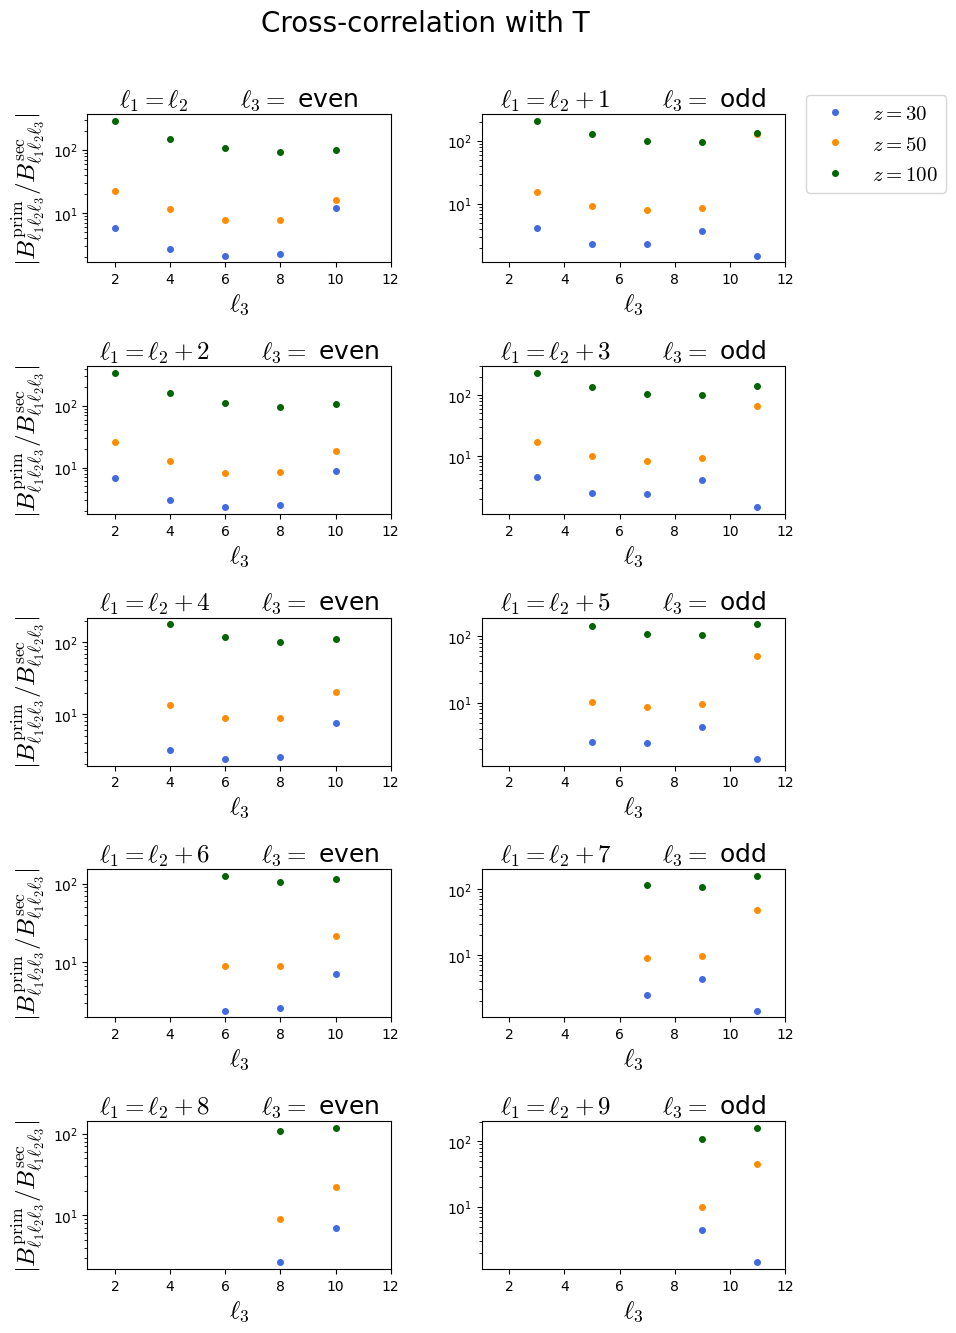

In [76]:
# plot prim/sec <21-21-T>

fig, ((ax1,ax7), (ax2,ax8), (ax3,ax9), (ax4,ax10), (ax5,ax11)) = plt.subplots(nrows=5, ncols=2, figsize=(9, 15))


fig.suptitle('Cross-correlation with T', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 = \ell_2 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 = \ell_2+2 \qquad$ $\ell_3=$ even', fontsize=18)
ax3.set_title(r'$\ell_1 = \ell_2+4 \qquad$ $\ell_3=$ even', fontsize=18)
ax4.set_title(r'$\ell_1 = \ell_2+6 \qquad$ $\ell_3=$ even', fontsize=18)
ax5.set_title(r'$\ell_1 = \ell_2+8 \qquad$ $\ell_3=$ even', fontsize=18)

ax7.set_title(r'$\ell_1 = \ell_2+1 \qquad$ $\ell_3=$ odd', fontsize=18)
ax8.set_title(r'$\ell_1 = \ell_2+3 \qquad$ $\ell_3=$ odd', fontsize=18)
ax9.set_title(r'$\ell_1 = \ell_2+5 \qquad$ $\ell_3=$ odd', fontsize=18)
ax10.set_title(r'$\ell_1 = \ell_2+7 \qquad$ $\ell_3=$ odd', fontsize=18)
ax11.set_title(r'$\ell_1 = \ell_2+9 \qquad$ $\ell_3=$ odd', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)
ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)
ax5.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)
ax9.set_xlabel(r'$\ell_3$', fontsize=18)
ax10.set_xlabel(r'$\ell_3$', fontsize=18)
ax11.set_xlabel(r'$\ell_3$', fontsize=18)



ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)

ax7.set_xlim(1,12)
ax8.set_xlim(1,12)
ax9.set_xlim(1,12)
ax10.set_xlim(1,12)
ax11.set_xlim(1,12)



ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax2.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax4.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')

ax7.set_yscale('log')
ax8.set_yscale('log')
ax9.set_yscale('log')
ax10.set_yscale('log')
ax11.set_yscale('log')


ax1.plot(l3plote,np.abs(np.array(Bprim30_ll)/np.array(Bsec30_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50_ll)/np.array(Bsec50_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100_ll)/np.array(Bsec100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)



ax2.plot(l3plote,np.abs(np.array(Bprim30_ll2)/np.array(Bsec30_ll2)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim50_ll2)/np.array(Bsec50_ll2)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim100_ll2)/np.array(Bsec100_ll2)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax3.plot(l3plote[1:],np.abs(np.array(Bprim30_ll4)[1:]/np.array(Bsec30_ll4)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim50_ll4)[1:]/np.array(Bsec50_ll4)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim100_ll4)[1:]/np.array(Bsec100_ll4)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax4.plot(l3plote[2:],np.abs(np.array(Bprim30_ll6)[2:]/np.array(Bsec30_ll6)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim50_ll6)[2:]/np.array(Bsec50_ll6)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim100_ll6)[2:]/np.array(Bsec100_ll6)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax5.plot(l3plote[3:],np.abs(np.array(Bprim30_ll8)[3:]/np.array(Bsec30_ll8)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim50_ll8)[3:]/np.array(Bsec50_ll8)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim100_ll8)[3:]/np.array(Bsec100_ll8)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)




ax7.plot(l3ploto,np.abs(np.array(Bprim30_ll1)/np.array(Bsec30_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim50_ll1)/np.array(Bsec50_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim100_ll1)/np.array(Bsec100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax7.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)



ax8.plot(l3ploto,np.abs(np.array(Bprim30_ll3)/np.array(Bsec30_ll3)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim50_ll3)/np.array(Bsec50_ll3)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim100_ll3)/np.array(Bsec100_ll3)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax9.plot(l3ploto[1:],np.abs(np.array(Bprim30_ll5)[1:]/np.array(Bsec30_ll5)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim50_ll5)[1:]/np.array(Bsec50_ll5)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim100_ll5)[1:]/np.array(Bsec100_ll5)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax10.plot(l3ploto[2:],np.abs(np.array(Bprim30_ll7)[2:]/np.array(Bsec30_ll7)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim50_ll7)[2:]/np.array(Bsec50_ll7)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim100_ll7)[2:]/np.array(Bsec100_ll7)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax11.plot(l3ploto[3:],np.abs(np.array(Bprim30_ll9)[3:]/np.array(Bsec30_ll9)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim50_ll9)[3:]/np.array(Bsec50_ll9)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim100_ll9)[3:]/np.array(Bsec100_ll9)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


plt.savefig("prims_vs_sec.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

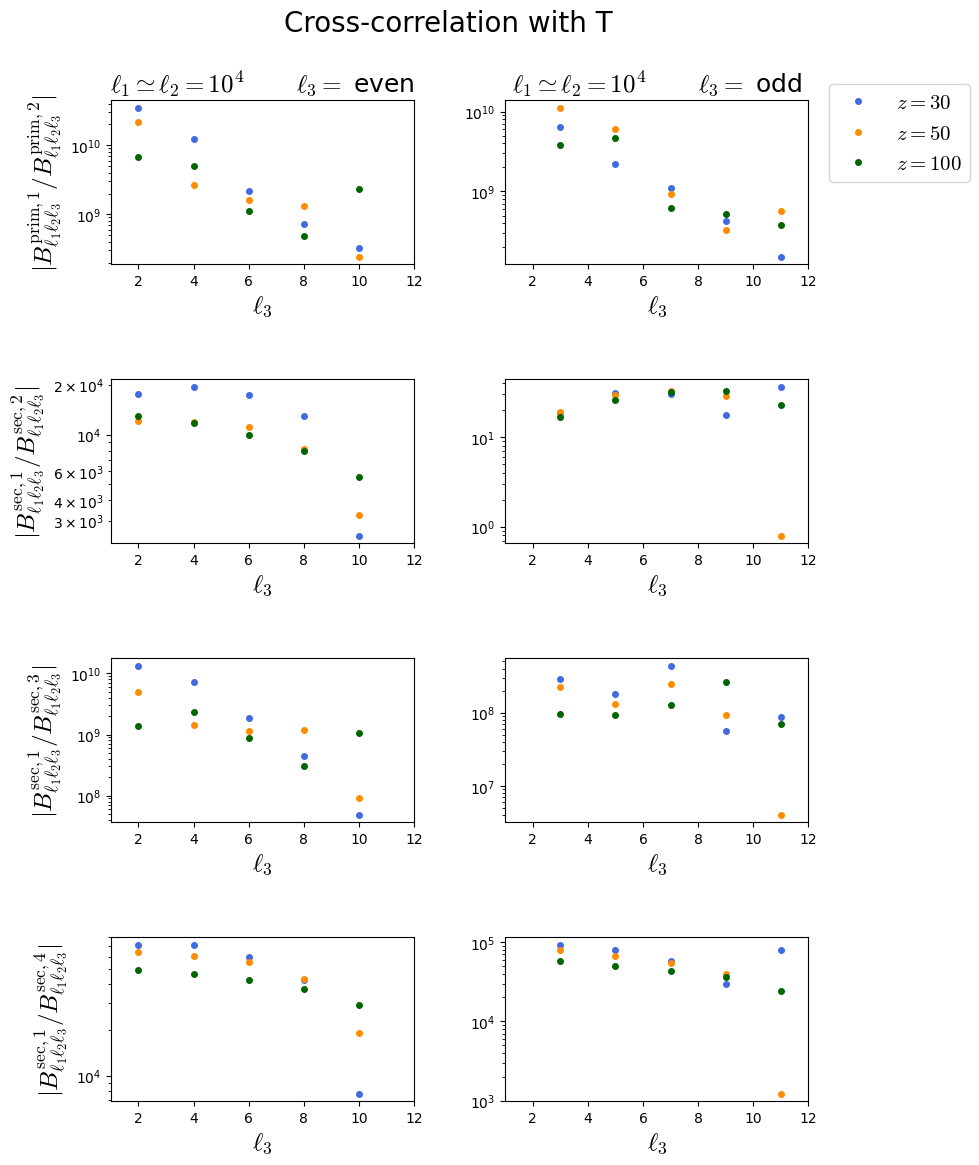

In [77]:
# plot prim1/otherprim and sec1/othersec, <21-21-T>

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(9, 13))



fig.suptitle('Cross-correlation with T', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ odd', fontsize=18)



ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)

ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)

ax5.set_xlabel(r'$\ell_3$', fontsize=18)
ax6.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)





ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)
ax6.set_xlim(1,12)
ax7.set_xlim(1,12)
ax8.set_xlim(1,12)




ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 2}|$', fontsize=18)


ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 2}|$', fontsize=18)


ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 3}|$', fontsize=18)


ax7.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 4}|$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')
ax8.set_yscale('log')

ax1.plot(l3plote,np.abs(np.array(Bprim30_ll)/np.array(Bprim230_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50_ll)/np.array(Bprim250_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100_ll)/np.array(Bprim2100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax2.plot(l3ploto,np.abs(np.array(Bprim30_ll1)/np.array(Bprim230_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim50_ll1)/np.array(Bprim250_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim100_ll1)/np.array(Bprim2100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


ax3.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec230_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec250_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec2100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax4.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec230_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec250_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec2100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax5.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec330_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec350_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec3100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax6.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec330_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec350_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec3100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax7.plot(l3plote,np.abs(np.array(Bsec130_ll)/np.array(Bsec430_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec150_ll)/np.array(Bsec450_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec1100_ll)/np.array(Bsec4100_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax8.plot(l3ploto,np.abs(np.array(Bsec130_ll1)/np.array(Bsec430_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec150_ll1)/np.array(Bsec450_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec1100_ll1)/np.array(Bsec4100_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)






plt.savefig("match_terms_T.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

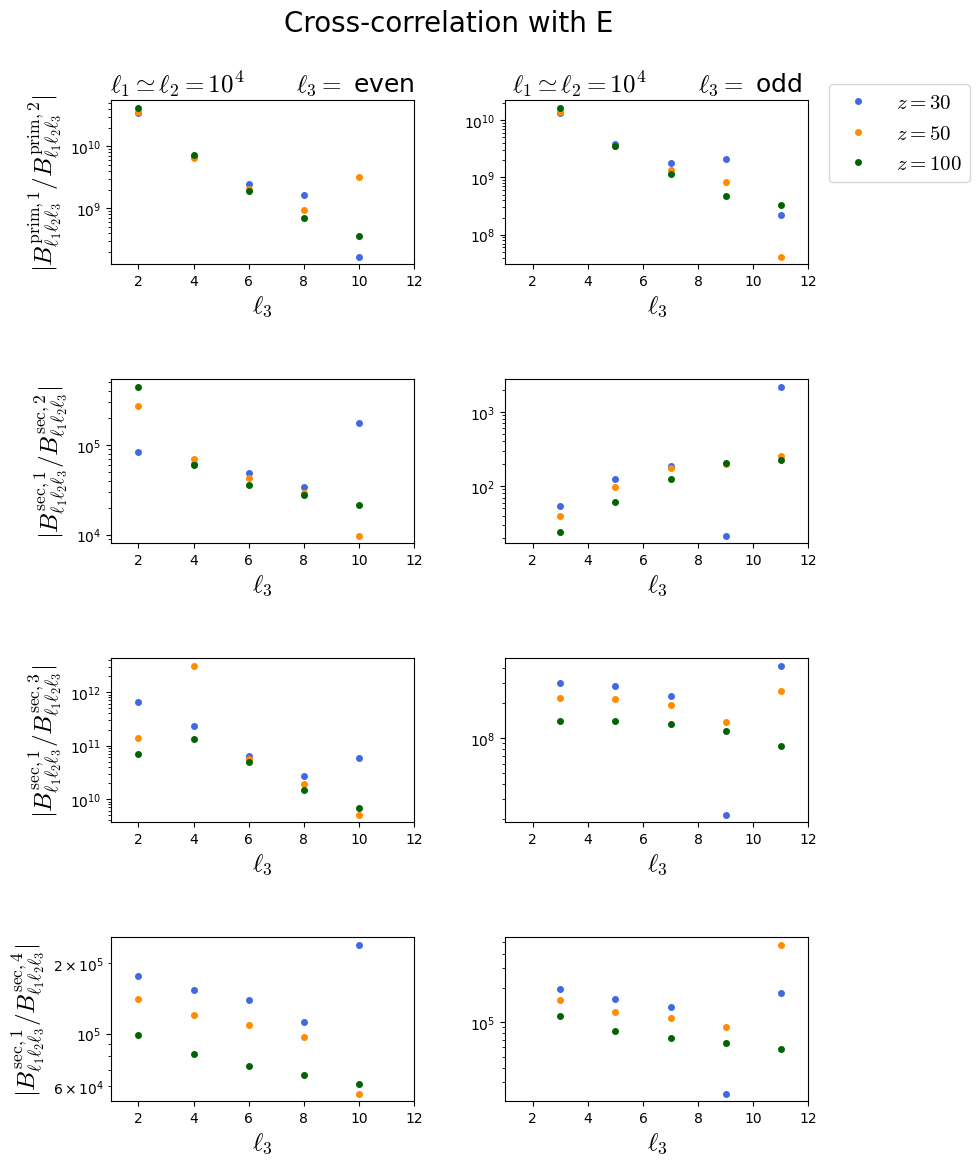

In [78]:
# plot prim1/otherprim sec1/othersec <21-21-E>

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(9, 13))


fig.suptitle('Cross-correlation with E', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 \simeq \ell_2 = 10^4 \qquad$ $ \ell_3=$ odd', fontsize=18)



ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)

ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)

ax5.set_xlabel(r'$\ell_3$', fontsize=18)
ax6.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)





ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)
ax6.set_xlim(1,12)
ax7.set_xlim(1,12)
ax8.set_xlim(1,12)




ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm prim, 2}|$', fontsize=18)


ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 2}|$', fontsize=18)


ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 3}|$', fontsize=18)


ax7.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 1}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec, 4}|$', fontsize=18)



ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')
ax8.set_yscale('log')

ax1.plot(l3plote,np.abs(np.array(Bprim30pol_ll)/np.array(Bprim230pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50pol_ll)/np.array(Bprim250pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100pol_ll)/np.array(Bprim2100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax2.plot(l3ploto,np.abs(np.array(Bprim30pol_ll1)/np.array(Bprim230pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim50pol_ll1)/np.array(Bprim250pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3ploto,np.abs(np.array(Bprim100pol_ll1)/np.array(Bprim2100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax2.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)


ax3.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec230pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec250pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec2100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax4.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec230pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec250pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec2100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax5.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec330pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec350pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec3100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax6.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec330pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec350pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax6.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec3100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax7.plot(l3plote,np.abs(np.array(Bsec130pol_ll)/np.array(Bsec430pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec150pol_ll)/np.array(Bsec450pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3plote,np.abs(np.array(Bsec1100pol_ll)/np.array(Bsec4100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


ax8.plot(l3ploto,np.abs(np.array(Bsec130pol_ll1)/np.array(Bsec430pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec150pol_ll1)/np.array(Bsec450pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bsec1100pol_ll1)/np.array(Bsec4100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)






plt.savefig("match_terms_E.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

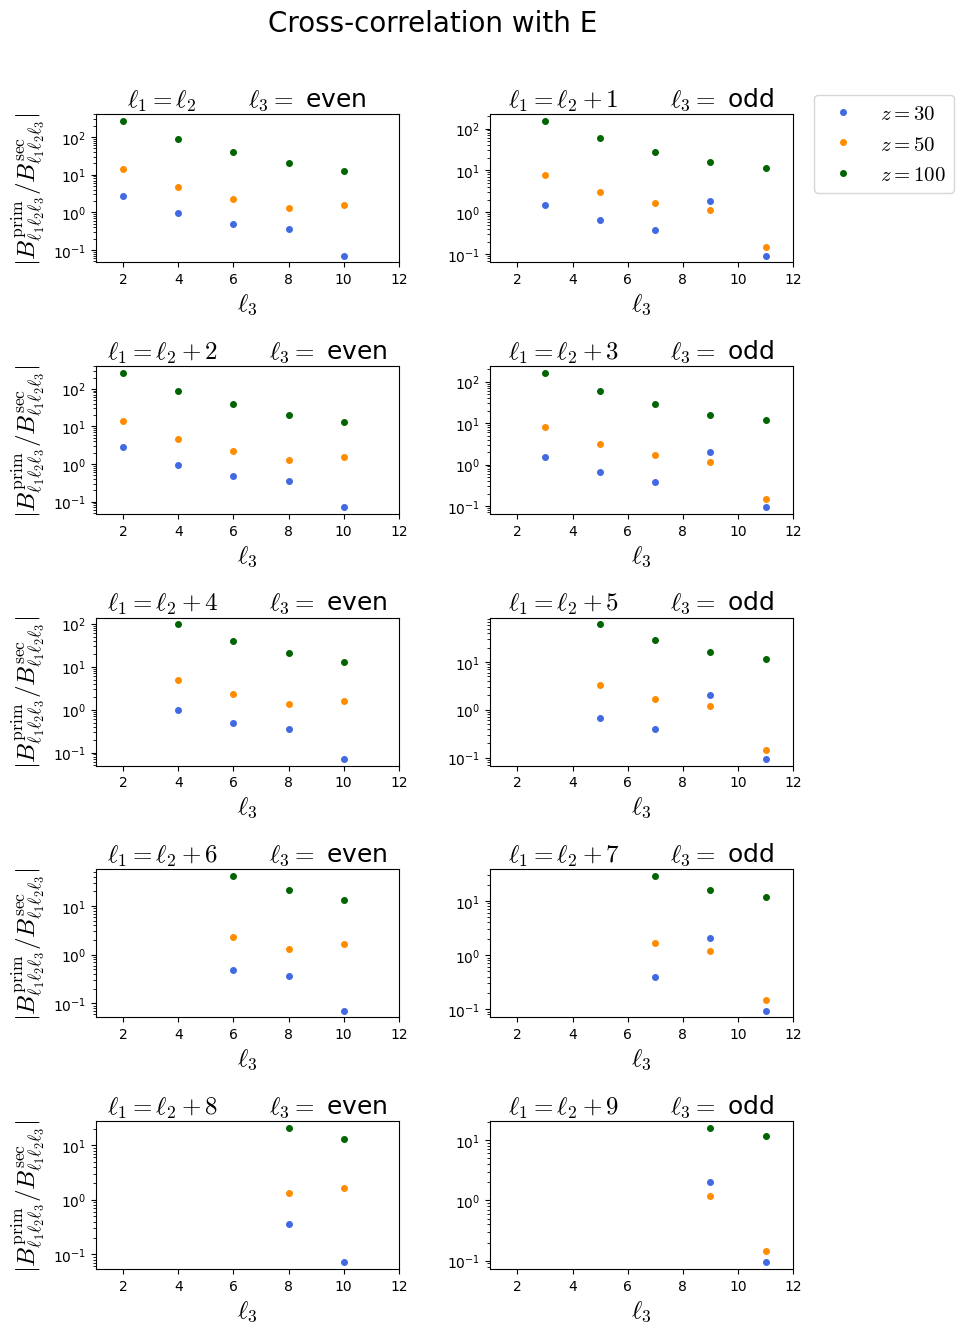

In [79]:
# plot prim/sec <21-21-E>

fig, ((ax1,ax7), (ax2,ax8), (ax3,ax9), (ax4,ax10), (ax5,ax11)) = plt.subplots(nrows=5, ncols=2, figsize=(9, 15))


fig.suptitle('Cross-correlation with E', fontsize=20,y=0.95)




fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.3)


ax1.set_title(r'$\ell_1 = \ell_2 \qquad$ $\ell_3=$ even', fontsize=18)
ax2.set_title(r'$\ell_1 = \ell_2+2 \qquad$ $\ell_3=$ even', fontsize=18)
ax3.set_title(r'$\ell_1 = \ell_2+4 \qquad$ $\ell_3=$ even', fontsize=18)
ax4.set_title(r'$\ell_1 = \ell_2+6 \qquad$ $\ell_3=$ even', fontsize=18)
ax5.set_title(r'$\ell_1 = \ell_2+8 \qquad$ $\ell_3=$ even', fontsize=18)

ax7.set_title(r'$\ell_1 = \ell_2+1 \qquad$ $\ell_3=$ odd', fontsize=18)
ax8.set_title(r'$\ell_1 = \ell_2+3 \qquad$ $\ell_3=$ odd', fontsize=18)
ax9.set_title(r'$\ell_1 = \ell_2+5 \qquad$ $\ell_3=$ odd', fontsize=18)
ax10.set_title(r'$\ell_1 = \ell_2+7 \qquad$ $\ell_3=$ odd', fontsize=18)
ax11.set_title(r'$\ell_1 = \ell_2+9 \qquad$ $\ell_3=$ odd', fontsize=18)


ax1.set_xlabel(r'$\ell_3$', fontsize=18)
ax2.set_xlabel(r'$\ell_3$', fontsize=18)
ax3.set_xlabel(r'$\ell_3$', fontsize=18)
ax4.set_xlabel(r'$\ell_3$', fontsize=18)
ax5.set_xlabel(r'$\ell_3$', fontsize=18)

ax7.set_xlabel(r'$\ell_3$', fontsize=18)
ax8.set_xlabel(r'$\ell_3$', fontsize=18)
ax9.set_xlabel(r'$\ell_3$', fontsize=18)
ax10.set_xlabel(r'$\ell_3$', fontsize=18)
ax11.set_xlabel(r'$\ell_3$', fontsize=18)



ax1.set_xlim(1,12)
ax2.set_xlim(1,12)
ax3.set_xlim(1,12)
ax4.set_xlim(1,12)
ax5.set_xlim(1,12)

ax7.set_xlim(1,12)
ax8.set_xlim(1,12)
ax9.set_xlim(1,12)
ax10.set_xlim(1,12)
ax11.set_xlim(1,12)



ax1.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax2.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax3.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax4.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)
ax5.set_ylabel(r'$|B_{\ell_1 \ell_2 \ell_3}^{\rm prim}/B_{\ell_1 \ell_2 \ell_3}^{\rm sec}|$', fontsize=18)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')

ax7.set_yscale('log')
ax8.set_yscale('log')
ax9.set_yscale('log')
ax10.set_yscale('log')
ax11.set_yscale('log')


ax1.plot(l3plote,np.abs(np.array(Bprim30pol_ll)/np.array(Bsec30pol_ll)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim50pol_ll)/np.array(Bsec50pol_ll)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax1.plot(l3plote,np.abs(np.array(Bprim100pol_ll)/np.array(Bsec100pol_ll)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)



ax2.plot(l3plote,np.abs(np.array(Bprim30pol_ll2)/np.array(Bsec30pol_ll2)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim50pol_ll2)/np.array(Bsec50pol_ll2)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax2.plot(l3plote,np.abs(np.array(Bprim100pol_ll2)/np.array(Bsec100pol_ll2)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax3.plot(l3plote[1:],np.abs(np.array(Bprim30pol_ll4)[1:]/np.array(Bsec30pol_ll4)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim50pol_ll4)[1:]/np.array(Bsec50pol_ll4)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax3.plot(l3plote[1:],np.abs(np.array(Bprim100pol_ll4)[1:]/np.array(Bsec100pol_ll4)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax4.plot(l3plote[2:],np.abs(np.array(Bprim30pol_ll6)[2:]/np.array(Bsec30pol_ll6)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim50pol_ll6)[2:]/np.array(Bsec50pol_ll6)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax4.plot(l3plote[2:],np.abs(np.array(Bprim100pol_ll6)[2:]/np.array(Bsec100pol_ll6)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax5.plot(l3plote[3:],np.abs(np.array(Bprim30pol_ll8)[3:]/np.array(Bsec30pol_ll8)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim50pol_ll8)[3:]/np.array(Bsec50pol_ll8)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax5.plot(l3plote[3:],np.abs(np.array(Bprim100pol_ll8)[3:]/np.array(Bsec100pol_ll8)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)




ax7.plot(l3ploto,np.abs(np.array(Bprim30pol_ll1)/np.array(Bsec30pol_ll1)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim50pol_ll1)/np.array(Bsec50pol_ll1)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax7.plot(l3ploto,np.abs(np.array(Bprim100pol_ll1)/np.array(Bsec100pol_ll1)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax7.legend(bbox_to_anchor=(1.3, 0.80), loc='center', ncol = 1, borderaxespad=0., fontsize=15)#(loc='best', fontsize=20)



ax8.plot(l3ploto,np.abs(np.array(Bprim30pol_ll3)/np.array(Bsec30pol_ll3)),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim50pol_ll3)/np.array(Bsec50pol_ll3)),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax8.plot(l3ploto,np.abs(np.array(Bprim100pol_ll3)/np.array(Bsec100pol_ll3)),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax9.plot(l3ploto[1:],np.abs(np.array(Bprim30pol_ll5)[1:]/np.array(Bsec30pol_ll5)[1:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim50pol_ll5)[1:]/np.array(Bsec50pol_ll5)[1:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax9.plot(l3ploto[1:],np.abs(np.array(Bprim100pol_ll5)[1:]/np.array(Bsec100pol_ll5)[1:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax10.plot(l3ploto[2:],np.abs(np.array(Bprim30pol_ll7)[2:]/np.array(Bsec30pol_ll7)[2:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim50pol_ll7)[2:]/np.array(Bsec50pol_ll7)[2:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax10.plot(l3ploto[2:],np.abs(np.array(Bprim100pol_ll7)[2:]/np.array(Bsec100pol_ll7)[2:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)

ax11.plot(l3ploto[3:],np.abs(np.array(Bprim30pol_ll9)[3:]/np.array(Bsec30pol_ll9)[3:]),'o', label = r'$z=30$', color = 'royalblue',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim50pol_ll9)[3:]/np.array(Bsec50pol_ll9)[3:]),'o', label = r'$z=50$', color = 'darkorange',markersize=4)
ax11.plot(l3ploto[3:],np.abs(np.array(Bprim100pol_ll9)[3:]/np.array(Bsec100pol_ll9)[3:]),'o', label = r'$z=100$', color = 'darkgreen',markersize=4)


plt.savefig("prims_vs_secpol.pdf", dpi=300, bbox_inches='tight')


plt.show()
plt.close()

## PS, flat-sky exact vs full-sky Limber

In [318]:
# list of l for plot

llistpl = np.logspace(3,5,100)


In [319]:
# 21-cm PS exact flat sky

def c21(i,r,z,dnu):
    l= int(llistpl[i])
    
    if z == 30:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono30f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 50:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono50f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    elif z == 100:
        integrand = lambda q: Wq(q,z,dnu)**2*trans(q,l,r,z)**2*(mono100f(np.sqrt(q**2+l**2/r**2)))**2*scalarpower(np.sqrt(q**2+l**2/r**2))
    
    inte = scint.quad(integrand,0.0001,100,epsabs=0.,epsrel=1e-4, limit = 1000000)[0]
    factor = l**2/(2*np.pi)*(3/5)**2
    value = inte*factor/r**2/(2*np.pi)
    return value

In [320]:
# y-sampling for 21-cm PS computation- full sky Limber 

def cmseconda30(l):
    value = np.array([yp*W(r30,yp,30,0.1)**2*mono30f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y30])
    return value   

def cmseconda50(l):
    value = np.array([yp*W(r50,yp,50,0.1)**2*mono50f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y50])
    return value   

def cmseconda100(l):
    value = np.array([yp*W(r100,yp,100,0.1)**2*mono100f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y100])
    return value   

# y-sampling for 21-cm PS computation- full sky Limber - Deltaw = 1 MHz case  

def cmseconda301(l):
    value = np.array([yp*W(r30,yp,30,1)**2*mono30f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y301])
    return value   

def cmseconda501(l):
    value = np.array([yp*W(r50,yp,50,1)**2*mono50f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y501])
    return value   

def cmseconda1001(l):
    value = np.array([yp*W(r100,yp,100,1)**2*mono100f(l/yp)**2*alp1r(yp)**2*pars.scalar_power(l/yp) for yp in y1001])
    return value 

In [321]:
# 21-cm PS, limber+no velocity terms, for Fisher forecasts

def c2130(i,r,z,dnu):
    l= int(llist2[i])
    cms = cmseconda30(l)
    I2= integrate.simps(cms,x=y30, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c2150(i,r,z,dnu):
    l= int(llist2[i])
    cms = cmseconda50(l)
    I2= integrate.simps(cms,x=y50, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c21100(i,r,z,dnu):
    l= int(llist2[i])
    cms = cmseconda100(l)
    I2= integrate.simps(cms,x=y100, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

In [322]:
# 21-cm PS, limber+no velocity terms for plot

def c2130plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda30(l)
    I2= integrate.simps(cms,x=y30, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c2150plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda50(l)
    I2= integrate.simps(cms,x=y50, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c21100plt(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda100(l)
    I2= integrate.simps(cms,x=y100, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value


# 21-cm PS, limber+no velocity terms for plot - Deltaw = 1 MHz case 

def c2130plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda301(l)
    I2= integrate.simps(cms,x=y301, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c2150plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda501(l)
    I2= integrate.simps(cms,x=y501, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

def c21100plt1(i,r,z,dnu):
    l= int(llistpl[i])
    cms = cmseconda1001(l)
    I2= integrate.simps(cms,x=y1001, even='avg')
    factor = 2*np.pi**2/l**3*(3/5)**2
    value = I2*factor
    return value

In [324]:
# 21-cm PS computation, limber+no vel z=30, for Fisher-Forecast

C21r30w01=[c2130(i,r30,30,0.1) for i in range(len(llist2))]

In [325]:
# 21-cm PS computation, limber+no vel z=50, for Fisher-Forecast

C21r50w01=[c2150(i,r50,50,0.1) for i in range(len(llist2))]

In [326]:
# 21-cm PS computation, limber+no vel z=100, for Fisher-Forecast

C21r100w01=[c21100(i,r100,100,0.1) for i in range(len(llist2))]

In [327]:
# SAVE RESULTS

C21rawr30w01 = np.array([llist2, C21r30w01]).T
np.savetxt('C21rawr30w01.txt', C21rawr30w01)

C21rawr50w01 = np.array([llist2, C21r50w01]).T
np.savetxt('C21rawr50w01.txt', C21rawr50w01)

C21rawr100w01 = np.array([llist2, C21r100w01]).T
np.savetxt('C21rawr100w01.txt', C21rawr100w01)

In [328]:
# 21-cm PS Limber Delta_nu = 0.1 

C21r30w01plt=[np.sqrt(c2130plt(i,r30,30,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r50w01plt=[np.sqrt(c2150plt(i,r50,50,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r100w01plt=[np.sqrt(c21100plt(i,r100,100,0.1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]

In [329]:
# 21-cm PS Limber Delta_nu = 1 

C21r30w1plt=[np.sqrt(c2130plt1(i,r30,30,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r50w1plt=[np.sqrt(c2150plt1(i,r50,50,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]
C21r100w1plt=[np.sqrt(c21100plt1(i,r100,100,1)*llistpl[i]**2/(2*np.pi)) for i in range(len(llistpl))]

In [288]:
# 21-cm PS exact z = 30

C21r3001=[np.sqrt(c21(i,r30,30,0.1)) for i in range(len(llistpl))]

C21r301=[np.sqrt(c21(i,r30,30,1)) for i in range(len(llistpl))]

In [289]:
# 21-cm PS exact z = 50

C21r5001=[np.sqrt(c21(i,r50,50,0.1)) for i in range(len(llistpl))]

C21r501=[np.sqrt(c21(i,r50,50,1)) for i in range(len(llistpl))]

In [290]:
# 21-cm PS exact z = 100

C21r10001=[np.sqrt(c21(i,r100,100,0.1)) for i in range(len(llistpl))]

C21r1001=[np.sqrt(c21(i,r100,100,1)) for i in range(len(llistpl))]

In [291]:
# for plots

def kplot(x):
    value = x/r50
    return value

def invkplot(x):
    value = x*r50
    return value

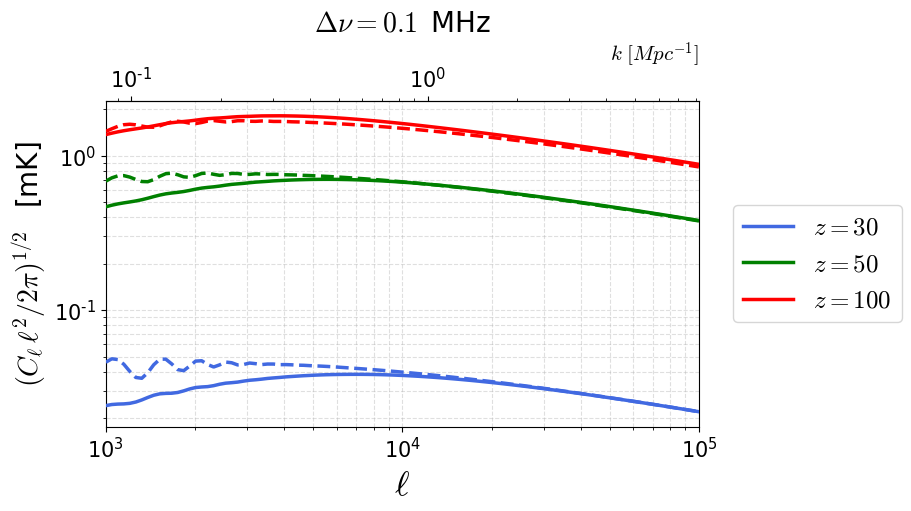

In [301]:
# plot 21-cm PS exact vs limber $\Delta \nu = 0.1 \,$ MHz

fig, ax1 = plt.subplots(layout='constrained',figsize=(9, 5))


ax1.set_xscale('log')

ax1.set_yscale('log')


plt.xlim(1e3,1e5)

ax1.plot(llistpl,C21r3001, label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r30w01plt, color = 'royalblue', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r5001, label = '$z=50$', color = 'green', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r50w01plt, color = 'green', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r10001, label = '$z=100$', color = 'red', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r100w01plt, color = 'red', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.set_xlabel(r'$\ell$', fontsize=25)
ax1.set_ylabel(r'$(C_\ell \, \ell^2/2\pi)^{1/2} \, $  [mK]', fontsize=20)
ax1.legend(bbox_to_anchor=(1.20, 0.5), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

ax1.set_title(r'$\Delta \nu = 0.1 \,$ MHz', fontsize=20)

ax1.tick_params(labelsize=15)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)


ax2 = ax1.secondary_xaxis("top",functions=(kplot,invkplot))
ax2.set_xlabel(r'$k \,\, [Mpc^{-1}]$', fontsize=15, loc="right")
ax2.tick_params(labelsize=15)

plt.savefig("21cm_power_0.1.pdf", dpi=300, bbox_inches='tight')
plt.show()

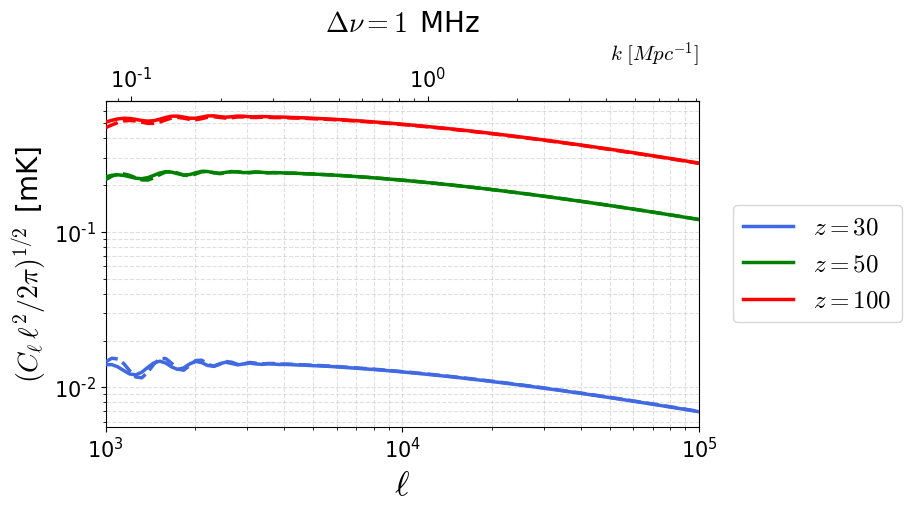

In [302]:
# plot 21-cm PS exact vs limber $\Delta \nu = 1 \,$ MHz

fig, ax1 = plt.subplots(layout='constrained',figsize=(9, 5))


ax1.set_xscale('log')

ax1.set_yscale('log')


plt.xlim(1e3,1e5)

ax1.plot(llistpl,C21r301, label = '$z=30$', color = 'royalblue', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r30w1plt, color = 'royalblue', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r501, label = '$z=50$', color = 'green', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r50w1plt, color = 'green', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.plot(llistpl,C21r1001, label = '$z=100$', color = 'red', linewidth = 2.5, linestyle = '-', zorder = 10)
ax1.plot(llistpl,C21r100w1plt, color = 'red', linewidth = 2.5, linestyle = '--', zorder = 10)

ax1.set_xlabel(r'$\ell$', fontsize=25)
ax1.set_ylabel(r'$(C_\ell \, \ell^2/2\pi)^{1/2} \, $ [mK]', fontsize=20)
ax1.legend(bbox_to_anchor=(1.20, 0.5), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

ax1.set_title(r'$\Delta \nu = 1 \,$ MHz', fontsize=20)

ax1.tick_params(labelsize=15)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)


ax2 = ax1.secondary_xaxis("top",functions=(kplot,invkplot))
ax2.set_xlabel(r'$k \,\, [Mpc^{-1}]$', fontsize=15, loc="right")
ax2.tick_params(labelsize=15)

plt.savefig("21cm_power_1.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Fisher matrix forecasts, SNR's

In [305]:
# Fisher terms 21-21-T primordial

def FisherCMBcm30(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = BcmCMBprim30(l1,l2,l3)**2/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/cTTspectra[l3-2]/D 
    return val

def FisherCMBcm50(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = BcmCMBprim50(l1,l2,l3)**2/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def FisherCMBcm100(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = BcmCMBprim100(l1,l2,l3)**2/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

In [306]:
# Fisher terms 21-21-T secondary (only I1)

def FisherCMBcm30sec(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (BcmCMBsecf30(l1,l2,l3))**2/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def FisherCMBcm50sec(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (BcmCMBsecf50(l1,l2,l3))**2/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/cTTspectra[l3-2]/D      
    return val

def FisherCMBcm100sec(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    val = (BcmCMBsecf100(l1,l2,l3))**2/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/cTTspectra[l3-2]/D      
    return val


In [308]:
# Fisher terms 21-21-T + 21-21-E primordial

def FisherCMBcm30TpE(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = BcmCMBprim30(l1,l2,l3)
    Bpol = BcmCMBprim30pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def FisherCMBcm50TpE(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = BcmCMBprim50(l1,l2,l3)
    Bpol = BcmCMBprim50pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def FisherCMBcm100TpE(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = BcmCMBprim100(l1,l2,l3)
    Bpol = BcmCMBprim100pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3

In [311]:
# Fisher terms 21-21-T + 21-21-E secondary (only I1)

def FisherCMBcm30TpEsec(l1,l2,l3): 
    D = 1
    if l1 == l2: 
        D=2 
    B = BcmCMBsecf30(l1,l2,l3)
    Bpol = BcmCMBsecf30pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r30w01[l1-10000])/np.array(C21r30w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def FisherCMBcm50TpEsec(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = BcmCMBsecf50(l1,l2,l3)
    Bpol = BcmCMBsecf50pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r50w01[l1-10000])/np.array(C21r50w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3


def FisherCMBcm100TpEsec(l1,l2,l3): 
    D = 1
    if l1 == l2:
        D=2
    B = BcmCMBsecf100(l1,l2,l3)
    Bpol = BcmCMBsecf100pol(l1,l2,l3)
    val1 = B**2*cEEspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val2 = Bpol**2*cTTspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    val3 = -2*B*Bpol*cETspectra[l3-2]/np.array(C21r100w01[l1-10000])/np.array(C21r100w01[l2-10000])/(cTTspectra[l3-2]*cEEspectra[l3-2]-cETspectra[l3-2]**2)/D
    return val1+val2+val3

In [312]:
# Computation Fisher matrix 21-21-T primordial

def DeltaFisherCMBcm30(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm30(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm50(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm50(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm100(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm100(llist2[i1],l2,l3list[i3]) 
    return val

In [314]:
# Computation Fisher matrix 21-21-T secondary

def DeltaFisherCMBcm30sec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm30sec(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm50sec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm50sec(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm100sec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm100sec(llist2[i1],l2,l3list[i3]) 
    return val

In [330]:
# Computation Fisher matrix 21-21-T + 21-21-E primary

def DeltaFisherCMBcm30TpE(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm30TpE(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm50TpE(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm50TpE(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm100TpE(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm100TpE(llist2[i1],l2,l3list[i3]) 
    return val

In [331]:
# Computation Fisher matrix 21-21-T + 21-21-E secondary

def DeltaFisherCMBcm30TpEsec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm30TpEsec(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm50TpEsec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm50TpEsec(llist2[i1],l2,l3list[i3]) 
    return val


def DeltaFisherCMBcm100TpEsec(l3list,llist2):
    val = np.zeros((len(l3list),len(llist2)))
    for i3 in range(len(l3list)):
        for i1 in range(len(llist2)):
            l2list = np.arange(llist2[i1],llist2[i1]+l3list[i3]+1)
            val[i3,i1] = val[i3,i1-1]
            for l2 in l2list:
                if (l2+llist2[i1]+l3list[i3]) % 2== 0:
                    val[i3,i1] = val[i3,i1] + FisherCMBcm100TpEsec(llist2[i1],l2,l3list[i3]) 
    return val

In [332]:
# fix l1min, l1max

llist2r = np.arange(10000,100001)

In [ ]:
# Computing and saving S/N_sec ratios (F-matrix_sec) as function of l1max and l3max, takes 1 hour for red-shift 
# taking l3max = 11, only T case 

deltafnl30sec = DeltaFisherCMBcm30sec(l3list,llist2r)
deltafnl50sec = DeltaFisherCMBcm50sec(l3list,llist2r)
deltafnl100sec = DeltaFisherCMBcm100sec(l3list,llist2r)


deltafnl30vsl1sec = np.sum(deltafnl30sec,axis=0)
deltafnl50vsl1sec = np.sum(deltafnl50sec,axis=0)
deltafnl100vsl1sec = np.sum(deltafnl100sec,axis=0)


deltaFnl30vsl1sec = np.array([llist2r,np.sqrt(1/deltafnl30vsl1sec)]).T
np.savetxt('deltaFnl30vsl1sec.txt', deltaFnl30vsl1sec)
deltaFnl50vsl1sec = np.array([llist2r,np.sqrt(1/deltafnl50vsl1sec)]).T
np.savetxt('deltaFnl50vsl1sec.txt', deltaFnl50vsl1sec)
deltaFnl100vsl1sec = np.array([llist2r,np.sqrt(1/deltafnl100vsl1sec)]).T
np.savetxt('deltaFnl100vsl1sec.txt', deltaFnl100vsl1sec)


deltafnl30vsl3sec = deltafnl30sec[:,-1]
deltafnl50vsl3sec = deltafnl50sec[:,-1]
deltafnl100vsl3sec = deltafnl100sec[:,-1]


invdeltafnlpl30sec = [deltafnl30vsl3sec[0]]
invdeltafnlpl50sec = [deltafnl50vsl3sec[0]]
invdeltafnlpl100sec = [deltafnl100vsl3sec[0]]

for i in range(len(l3list)-1):
    invdeltafnlpl30sec.append(invdeltafnlpl30sec[i]+deltafnl30vsl3sec[i+1])
    invdeltafnlpl50sec.append(invdeltafnlpl50sec[i]+deltafnl50vsl3sec[i+1])
    invdeltafnlpl100sec.append(invdeltafnlpl100sec[i]+deltafnl100vsl3sec[i+1])
    
invdeltafnlpl30sec = np.array(invdeltafnlpl30sec) 
invdeltafnlpl50sec = np.array(invdeltafnlpl50sec)
invdeltafnlpl100sec = np.array(invdeltafnlpl100sec)

deltafnlpl30sec = np.sqrt(1/invdeltafnlpl30sec)
deltafnlpl50sec = np.sqrt(1/invdeltafnlpl50sec)   
deltafnlpl100sec = np.sqrt(1/invdeltafnlpl100sec) 


deltaFnl30vsl3sec = np.array([l3list,deltafnlpl30sec]).T
np.savetxt('deltaFnl30vsl3sec.txt', deltaFnl30vsl3sec)

deltaFnl50vsl3sec = np.array([l3list,deltafnlpl50sec]).T
np.savetxt('deltaFnl50vsl3sec.txt', deltaFnl50vsl3sec)

deltaFnl100vsl3sec = np.array([l3list,deltafnlpl100sec]).T
np.savetxt('deltaFnl100vsl3sec.txt', deltaFnl100vsl3sec)


In [ ]:
# Computing and saving S/N_sec ratios (F-matrix_sec) as function of l1max and l3max, takes 2 hours for red-shift 
# taking l3max = 11, T+E case

deltafnl30TpEsec = DeltaFisherCMBcm30TpEsec(l3list,llist2r)
deltafnl50TpEsec = DeltaFisherCMBcm50TpEsec(l3list,llist2r)
deltafnl100TpEsec = DeltaFisherCMBcm100TpEsec(l3list,llist2r)


deltafnl30vsl1TpEsec = np.sum(deltafnl30TpEsec,axis=0)
deltafnl50vsl1TpEsec = np.sum(deltafnl50TpEsec,axis=0)
deltafnl100vsl1TpEsec = np.sum(deltafnl100TpEsec,axis=0)


deltaFnl30vsl1TpEsec = np.array([llist2r,np.sqrt(1/deltafnl30vsl1TpEsec)]).T
np.savetxt('deltaFnl30vsl1TpEsec.txt', deltaFnl30vsl1TpEsec)
deltaFnl50vsl1TpEsec = np.array([llist2r,np.sqrt(1/deltafnl50vsl1TpEsec)]).T
np.savetxt('deltaFnl50vsl1TpEsec.txt', deltaFnl50vsl1TpEsec)
deltaFnl100vsl1TpEsec = np.array([llist2r,np.sqrt(1/deltafnl100vsl1TpEsec)]).T
np.savetxt('deltaFnl100vsl1TpEsec.txt', deltaFnl100vsl1TpEsec)


deltafnl30vsl3TpEsec = deltafnl30TpEsec[:,-1]
deltafnl50vsl3TpEsec = deltafnl50TpEsec[:,-1]
deltafnl100vsl3TpEsec = deltafnl100TpEsec[:,-1]


invdeltafnlpl30TpEsec = [deltafnl30vsl3TpEsec[0]]
invdeltafnlpl50TpEsec = [deltafnl50vsl3TpEsec[0]]
invdeltafnlpl100TpEsec = [deltafnl100vsl3TpEsec[0]]

for i in range(len(l3list)-1):
    invdeltafnlpl30TpEsec.append(invdeltafnlpl30TpEsec[i]+deltafnl30vsl3TpEsec[i+1])
    invdeltafnlpl50TpEsec.append(invdeltafnlpl50TpEsec[i]+deltafnl50vsl3TpEsec[i+1])
    invdeltafnlpl100TpEsec.append(invdeltafnlpl100TpEsec[i]+deltafnl100vsl3TpEsec[i+1])

invdeltafnlpl30TpEsec = np.array(invdeltafnlpl30TpEsec) 
invdeltafnlpl50TpEsec = np.array(invdeltafnlpl50TpEsec)
invdeltafnlpl100TpEsec = np.array(invdeltafnlpl100TpEsec)

deltafnlpl30TpEsec = np.sqrt(1/invdeltafnlpl30TpEsec)
deltafnlpl50TpEsec = np.sqrt(1/invdeltafnlpl50TpEsec)
deltafnlpl100TpEsec = np.sqrt(1/invdeltafnlpl100TpEsec)



deltaFnl30vsl3TpEsec = np.array([l3list,deltafnlpl30TpEsec]).T
np.savetxt('deltaFnl30vsl3TpEsec.txt', deltaFnl30vsl3TpEsec)
deltaFnl50vsl3TpEsec = np.array([l3list,deltafnlpl50TpEsec]).T
np.savetxt('deltaFnl50vsl3TpEsec.txt', deltaFnl50vsl3TpEsec)
deltaFnl100vsl3TpEsec = np.array([l3list,deltafnlpl100TpEsec]).T
np.savetxt('deltaFnl100vsl3TpEsec.txt', deltaFnl100vsl3TpEsec)


In [ ]:
# Computing and saving S/N_prim ratios (F-matrix_prim) as function of l1max and l3max, takes 1/2 hours for red-shift 
# taking l3max = 11, both T and T+E case

deltafnl30 = DeltaFisherCMBcm30(l3list,llist2r)
deltafnl50 = DeltaFisherCMBcm50(l3list,llist2r)
deltafnl100 = DeltaFisherCMBcm100(l3list,llist2r)


deltafnl30TpE = DeltaFisherCMBcm30TpE(l3list,llist2r)
deltafnl50TpE = DeltaFisherCMBcm50TpE(l3list,llist2r)
deltafnl100TpE = DeltaFisherCMBcm100TpE(l3list,llist2r)


deltafnl30vsl1 = np.sum(deltafnl30,axis=0)
deltafnl50vsl1 = np.sum(deltafnl50,axis=0)
deltafnl100vsl1 = np.sum(deltafnl100,axis=0)


deltafnl30vsl3 = deltafnl30[:,-1]
deltafnl50vsl3 = deltafnl50[:,-1]
deltafnl100vsl3 = deltafnl100[:,-1]


deltafnl30vsl1TpE = np.sum(deltafnl30TpE,axis=0)
deltafnl50vsl1TpE = np.sum(deltafnl50TpE,axis=0)
deltafnl100vsl1TpE = np.sum(deltafnl100TpE,axis=0)


deltafnl30vsl3TpE = deltafnl30TpE[:,-1]
deltafnl50vsl3TpE = deltafnl50TpE[:,-1]
deltafnl100vsl3TpE = deltafnl100TpE[:,-1]


deltaFnl30vsl1 = np.array([llist2r,np.sqrt(1/deltafnl30vsl1)]).T
np.savetxt('deltaFnl30vsl1.txt', deltaFnl30vsl1)
deltaFnl50vsl1 = np.array([llist2r,np.sqrt(1/deltafnl50vsl1)]).T
np.savetxt('deltaFnl50vsl1.txt', deltaFnl50vsl1)
deltaFnl100vsl1 = np.array([llist2r,np.sqrt(1/deltafnl100vsl1)]).T
np.savetxt('deltaFnl100vsl1.txt', deltaFnl100vsl1)


deltaFnl30vsl1TpE = np.array([llist2r,np.sqrt(1/deltafnl30vsl1TpE)]).T
np.savetxt('deltaFnl30vsl1TpE.txt', deltaFnl30vsl1TpE)
deltaFnl50vsl1TpE = np.array([llist2r,np.sqrt(1/deltafnl50vsl1TpE)]).T
np.savetxt('deltaFnl50vsl1TpE.txt', deltaFnl50vsl1TpE)
deltaFnl100vsl1TpE = np.array([llist2r,np.sqrt(1/deltafnl100vsl1TpE)]).T
np.savetxt('deltaFnl100vsl1TpE.txt', deltaFnl100vsl1TpE)


invdeltafnlpl30 = [deltafnl30vsl3[0]]
invdeltafnlpl50 = [deltafnl50vsl3[0]]
invdeltafnlpl100 = [deltafnl100vsl3[0]]

for i in range(len(l3list)-1):
    invdeltafnlpl30.append(invdeltafnlpl30[i]+deltafnl30vsl3[i+1])
    invdeltafnlpl50.append(invdeltafnlpl50[i]+deltafnl50vsl3[i+1])
    invdeltafnlpl100.append(invdeltafnlpl100[i]+deltafnl100vsl3[i+1])
    
invdeltafnlpl30 = np.array(invdeltafnlpl30) 
invdeltafnlpl50 = np.array(invdeltafnlpl50)
invdeltafnlpl100 = np.array(invdeltafnlpl100)

deltafnlpl30 = np.sqrt(1/invdeltafnlpl30)
deltafnlpl50 = np.sqrt(1/invdeltafnlpl50)   
deltafnlpl100 = np.sqrt(1/invdeltafnlpl100)


deltaFnl30vsl3 = np.array([l3list,deltafnlpl30]).T
np.savetxt('deltaFnl30vsl3.txt', deltaFnl30vsl3)
deltaFnl50vsl3 = np.array([l3list,deltafnlpl50]).T
np.savetxt('deltaFnl50vsl3.txt', deltaFnl50vsl3)
deltaFnl100vsl3 = np.array([l3list,deltafnlpl100]).T
np.savetxt('deltaFnl100vsl3.txt', deltaFnl100vsl3)


invdeltafnlpl30TpE = [deltafnl30vsl3TpE[0]]

for i in range(len(l3list)-1):
    invdeltafnlpl30TpE.append(invdeltafnlpl30TpE[i]+deltafnl30vsl3TpE[i+1])
    
invdeltafnlpl30TpE = np.array(invdeltafnlpl30TpE) 



invdeltafnlpl30TpE = [deltafnl30vsl3TpE[0]]
invdeltafnlpl50TpE = [deltafnl50vsl3TpE[0]]
invdeltafnlpl100TpE = [deltafnl100vsl3TpE[0]]

for i in range(len(l3list)-1):
    invdeltafnlpl30TpE.append(invdeltafnlpl30TpE[i]+deltafnl30vsl3TpE[i+1])
    invdeltafnlpl50TpE.append(invdeltafnlpl50TpE[i]+deltafnl50vsl3TpE[i+1])
    invdeltafnlpl100TpE.append(invdeltafnlpl100TpE[i]+deltafnl100vsl3TpE[i+1])

invdeltafnlpl30TpE = np.array(invdeltafnlpl30TpE) 
invdeltafnlpl50TpE = np.array(invdeltafnlpl50TpE) 
invdeltafnlpl100TpE = np.array(invdeltafnlpl100TpE) 

deltafnlpl30TpE = np.sqrt(1/invdeltafnlpl30TpE)
deltafnlpl50TpE = np.sqrt(1/invdeltafnlpl50TpE)
deltafnlpl100TpE = np.sqrt(1/invdeltafnlpl100TpE)



deltaFnl30vsl3TpE = np.array([l3list,deltafnlpl30TpE]).T
np.savetxt('deltaFnl30vsl3TpE.txt', deltaFnl30vsl3TpE)
deltaFnl50vsl3TpE = np.array([l3list,deltafnlpl50TpE]).T
np.savetxt('deltaFnl50vsl3TpE.txt', deltaFnl50vsl3TpE)
deltaFnl100vsl3TpE = np.array([l3list,deltafnlpl100TpE]).T
np.savetxt('deltaFnl100vsl3TpE.txt', deltaFnl100vsl3TpE)


# SNR ESTIMATED IN AN APPROXIMATED WAY

In [345]:
# SNR computed with approximated formula 53 of the paper

def SNR30(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R30[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)
    return SNR

def SNR50(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R50[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)
    return SNR

def SNR100(l3list):
    SNR = np.zeros(len(l3list))
    for i3 in range(len(l3list)):
        if l3list[i3] == 2 or l3list[i3] == 3:
            N = 2
        if l3list[i3] == 4 or l3list[i3] == 5:
            N = 3
        if l3list[i3] == 6 or l3list[i3] == 7:
            N = 4
        if l3list[i3] == 8 or l3list[i3] == 9:
            N = 5
        if l3list[i3] == 10 or l3list[i3] == 11:
            N = 6
        SNR[i3] =  SNR[i3-1] + R100[i3]*N
    SNR = 9.5e5*np.sqrt(SNR)
    return SNR
        

In [265]:
# computation

snr30 = SNR30(l3list)
snr50 = SNR50(l3list)
snr100 = SNR100(l3list)

# Plots SNR's

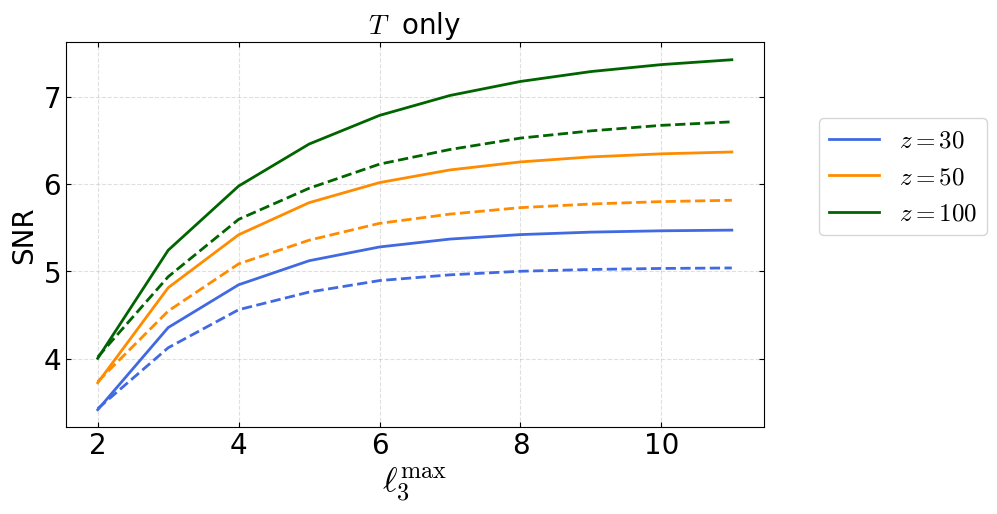

In [268]:
# T only vs l3max

plt.figure(figsize=(9,5))

plt.yscale("linear")

#plt.xlim(1e3,1e5)

plt.plot(deltaFnl30vsl3[:,0],1/deltaFnl30vsl3[:,1], label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl50vsl3[:,0],1/deltaFnl50vsl3[:,1], label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl100vsl3[:,0],1/deltaFnl100vsl3[:,1], label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

plt.plot(deltaFnl30vsl3[:,0],snr30, color = 'royalblue', linewidth = 2, linestyle = '--', zorder = 10)
plt.plot(deltaFnl50vsl3[:,0],snr50, color = 'darkorange', linewidth = 2, linestyle = '--', zorder = 10)
plt.plot(deltaFnl100vsl3[:,0],snr100, color = 'darkgreen', linewidth = 2, linestyle = '--', zorder = 10)



plt.xlabel(r'$\ell_3^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

plt.title(r'$T \, \,$ only', fontsize=20)


plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("squeez_DeltafNLvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()

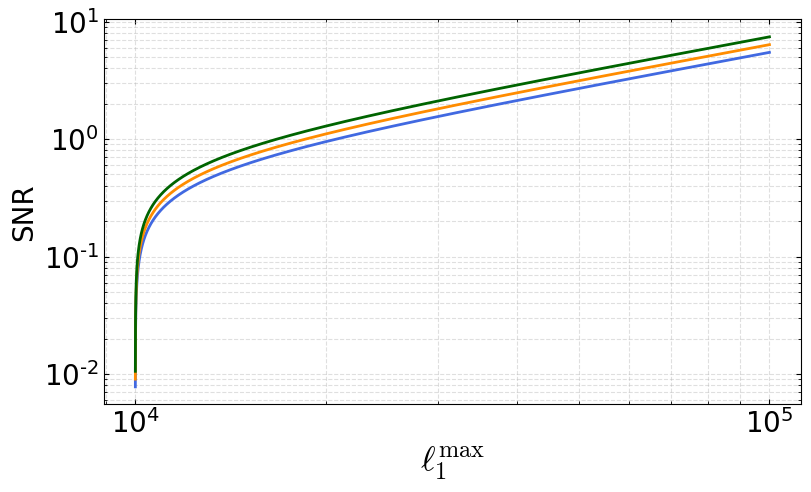

In [275]:
# T only vs l1max

plt.figure(figsize=(9,5))

plt.xscale("log")
plt.yscale("log")


#plt.xlim(1e3,1e5)

plt.plot(deltaFnl30vsl1[:,0],1/deltaFnl30vsl1[:,1], label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl50vsl1[:,0],1/deltaFnl50vsl1[:,1], label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl100vsl1[:,0],1/deltaFnl100vsl1[:,1], label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_1^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
#plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

#plt.title(r'$T \, \,$ only', fontsize=20)

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("squeez_DeltafNLvsl1.pdf", dpi=300, bbox_inches='tight')
plt.show()

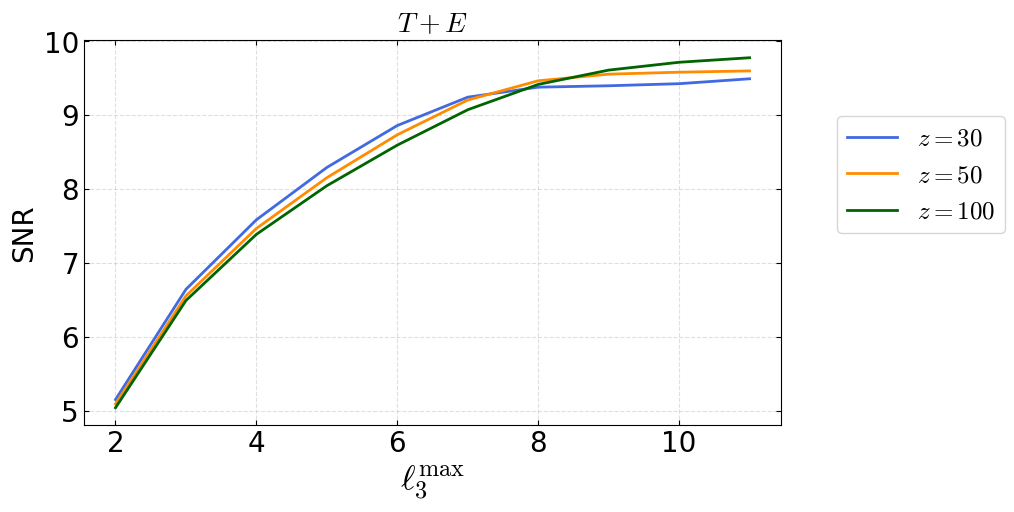

In [417]:
# T+E vs l3max

plt.figure(figsize=(9,5))

plt.yscale("linear")

#plt.xlim(1e3,1e5)

plt.plot(deltaFnl30vsl3TpE[:,0],1/deltaFnl30vsl3TpE[:,1], label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl50vsl3TpE[:,0],1/deltaFnl50vsl3TpE[:,1], label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
plt.plot(deltaFnl100vsl3TpE[:,0],1/deltaFnl100vsl3TpE[:,1], label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_3^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

plt.title(r'$T+E$', fontsize=20)


plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("squeez_DeltafNLvsl3TpE.pdf", dpi=300, bbox_inches='tight')
plt.show()

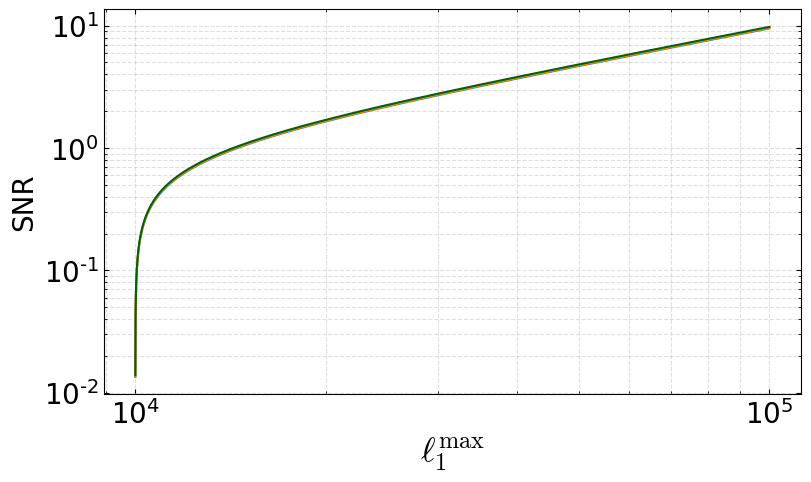

In [419]:
# T+E vs l1max

plt.figure(figsize=(9,5))

plt.xscale("log")
plt.yscale("log")


#plt.xlim(1e3,1e5)

plt.plot(deltaFnl30vsl1TpE[:,0],1/deltaFnl30vsl1TpE[:,1], label = r'$z=30$', color = 'royalblue', linewidth = 1.5, linestyle = '-', zorder = 10)
plt.plot(deltaFnl50vsl1TpE[:,0],1/deltaFnl50vsl1TpE[:,1], label = r'$z=50$', color = 'darkorange', linewidth = 1.5, linestyle = '-', zorder = 10)
plt.plot(deltaFnl100vsl1TpE[:,0],1/deltaFnl100vsl1TpE[:,1], label = r'$z=100$', color = 'darkgreen', linewidth = 1.5, linestyle = '-', zorder = 10)


plt.xlabel(r'$\ell_1^{\rm max}$', fontsize=25)
plt.ylabel(r'SNR', fontsize=20)
#plt.legend(bbox_to_anchor=(1.20, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)

#plt.title(r'$T \, \,$ only', fontsize=20)

plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
plt.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("squeez_DeltafNLvsl1TpE.pdf", dpi=300, bbox_inches='tight')
plt.show()

# BIAS TO F_NL^LOC MEASURE 

In [90]:
# unpacking things for estimating the bias to f_NL^loc measurement due to secondaries

l3, deltaprimT30 = np.loadtxt('deltaFnl30vsl3.txt', unpack = True)
_, deltaprimT50 = np.loadtxt('deltaFnl50vsl3.txt', unpack = True)
_, deltaprimT100 = np.loadtxt('deltaFnl100vsl3.txt', unpack = True)

_, deltaprimTE30 = np.loadtxt('deltaFnl30vsl3TpE.txt', unpack = True)
_, deltaprimTE50 = np.loadtxt('deltaFnl50vsl3TpE.txt', unpack = True)
_, deltaprimTE100 = np.loadtxt('deltaFnl100vsl3TpE.txt', unpack = True)

In [91]:
_, deltasecT30 = np.loadtxt('deltaFnl30vsl3sec.txt', unpack = True)
_, deltasecT50 = np.loadtxt('deltaFnl50vsl3sec.txt', unpack = True)
_, deltasecT100 = np.loadtxt('deltaFnl100vsl3sec.txt', unpack = True)

_, deltasecTE30 = np.loadtxt('deltaFnl30vsl3TpEsec.txt', unpack = True)
_, deltasecTE50 = np.loadtxt('deltaFnl50vsl3TpEsec.txt', unpack = True)
_, deltasecTE100 = np.loadtxt('deltaFnl100vsl3TpEsec.txt', unpack = True)

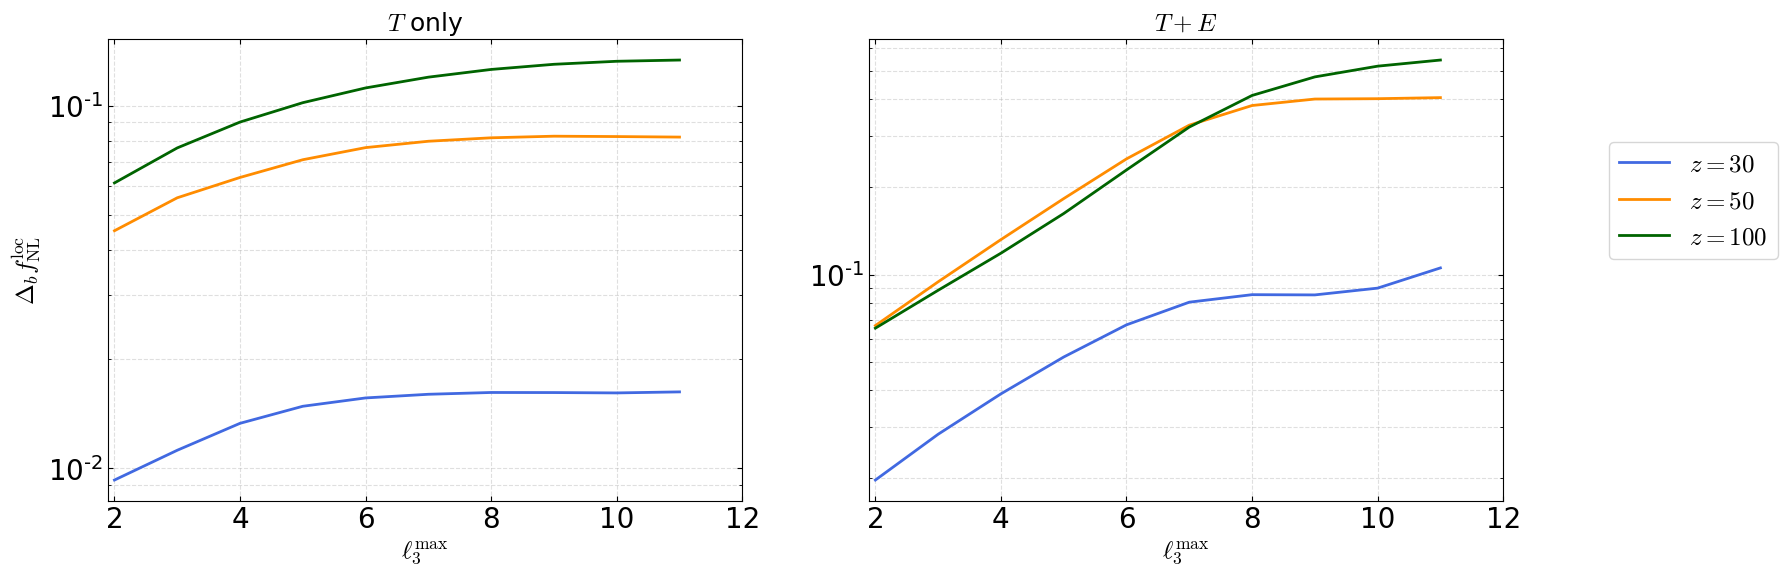

In [94]:
# Plot of estimated bias vs l3max


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6)
                        

ax1.set_title(r'$T$ only', fontsize=18)
ax2.set_title(r'$T+E$', fontsize=18)


ax1.set_xlabel(r'$\ell^{\rm max}_3$', fontsize=18)
ax2.set_xlabel(r'$\ell^{\rm max}_3$', fontsize=18)


ax1.set_xlim(1.9,12)
ax2.set_xlim(1.9,12)


ax1.set_ylabel(r'$\Delta_b f_{\rm NL}^{\rm loc}$', fontsize=18)


ax1.set_yscale('log')
ax2.set_yscale('log')


ax1.plot(l3,deltaprimT30/deltasecT30, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(l3,deltaprimT50/deltasecT50, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax1.plot(l3,deltaprimT100/deltasecT100, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)

ax2.plot(l3,deltaprimTE30/deltasecTE30, label = r'$z=30$', color = 'royalblue', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(l3,deltaprimTE50/deltasecTE50, label = r'$z=50$', color = 'darkorange', linewidth = 2, linestyle = '-', zorder = 10)
ax2.plot(l3,deltaprimTE100/deltasecTE100, label = r'$z=100$', color = 'darkgreen', linewidth = 2, linestyle = '-', zorder = 10)


ax2.legend(bbox_to_anchor=(1.30, 0.65), loc='center', ncol = 1, borderaxespad=0., fontsize=18)#(loc='best', fontsize=20)


ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax1.grid(True, which='both',linestyle='--', alpha = 0.4)

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax2.grid(True, which='both',linestyle='--', alpha = 0.4)

# plt.ylim([1e-13,7e1])

# ax1.set_ylim([1.4e-6,6.2e-6])
plt.savefig("biasfNLvsl3.pdf", dpi=300, bbox_inches='tight')
plt.show()